## V3.3 simulations ##

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rubin_sim.maf as maf

Read the information about the metric sets in this version of the sims outputs, as well as the summary.h5 file containing the summary stats from the runs. 

In [2]:
metric_sets = maf.get_metric_sets('metric_sets.json')
msets = list(metric_sets.groupby('metric set').first().index)

In [3]:
# https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.3/maf/summary.h5
summaries = maf.get_metric_summaries(summary_source='summary.h5')
summaries.index

Index(['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
       'baseline_v3.0_10yrs', 'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs',
       'ddf_half_v3.3_10yrs', 'ddf_loaded_fl15_v3.3_10yrs',
       'ddf_loaded_fl1_v3.3_10yrs', 'ddf_loaded_fl2_v3.3_10yrs',
       'ddf_loaded_fl4_v3.3_10yrs', 'ddf_loaded_fl8_v3.3_10yrs',
       'ddf_loaded_half_fl15_v3.3_10yrs', 'ddf_loaded_half_fl1_v3.3_10yrs',
       'ddf_loaded_half_fl2_v3.3_10yrs', 'ddf_loaded_half_fl4_v3.3_10yrs',
       'ddf_loaded_half_fl8_v3.3_10yrs', 'm2_baseline_v3.3_10yrs',
       'mw_roll_all_v3.3_10yrs', 'mw_roll_bulge_v3.3_10yrs',
       'no_high_blob_v3.3_10yrs', 'noroll_v3.3_10yrs',
       'retro_baseline_v2.0_10yrs', 'reweight_bulge_v3.3_10yrs',
       'reweight_plane_v3.3_10yrs', 'roll_mid1_const_season2v3.3_10yrs',
       'roll_mid1_const_season4v3.3_10yrs',
       'roll_mid1_const_season6v3.3_10yrs',
       'roll_mid1_const_season_v3.3_10yrs',
       'roll_mid2_const_season2v3.3_10yrs',
       'ro

Identify some subsets of runs that belong in common families. 

In [19]:
# Weather variations on baseline strategy
weather_runs = [r for r in summaries.index if 'weather' in r]
offsets = [int(w.split('dso')[-1].split('v3')[0]) for w in weather_runs]
idx = np.argsort(offsets)
weather_runs = [weather_runs[i] for i in idx]
weather_runs

# DDF variations
ddf = [r for r in summaries.index if 'ddf_' in r]
ddf

# Rolling variations
roll = [r for r in summaries.index if 'roll' in r]
roll

# Baseline sims
baselines = [r for r in summaries.index if 'baseline' in r]
versions = [float(r.split('_v')[-1].split('_10yrs')[0]) for r in baselines]
idx = np.argsort(versions)
baselines = [baselines[i] for i in idx]
# Rearrange to put retro first in list
tmp = baselines[0]
baselines[0] = baselines[1]
baselines[1] = tmp
# drop m2 baseline
baselines = baselines[:-1]
print(baselines)

baseline_run = 'baseline_v3.3_10yrs'

baseline_dict = {'retro_baseline_v2.0_10yrs': 'v1.x', 
                 'baseline_v2.0_10yrs':'v2.0', 
                 'baseline_v2.1_10yrs':'v2.1',
                 'baseline_v2.2_10yrs':'v2.2',
                 'baseline_v3.0_10yrs':'v3.0',
                 'baseline_v3.2_10yrs':'v3.2',
                'baseline_v3.3_10yrs':'v3.3'}

outdir = 'tmp_fig'
try:
    os.mkdir(outdir)
except:
    pass

['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs', 'baseline_v3.0_10yrs', 'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs']


We can derive approximate uncertainties for some of our relevant metrics by looking at their variation across the different 'weather' instances of the baseline strategy.
This isn't necessarily appropriate for all metrics, but it does give a useful indications.

In [20]:
# what are uncertainties -- we 
dev = np.std(summaries.loc[weather_runs], axis=0)
hilo = np.abs(summaries.loc[weather_runs].max() - summaries.loc[weather_runs].min())

nvis = [m for m in summaries if "Nvisits" in m and "UniSlicer" in m and 'All' in m]
print(f"example: Total NVisits (in millions) std dev {dev[nvis].iloc[0]/1e6: .2f}, range is {hilo[nvis].iloc[0]/1e6 :.2f}, baseline {summaries.loc[baseline_run, nvis].iloc[0]/1e6 :.2f}")

example: Total NVisits (in millions) std dev  0.04, range is 0.16, baseline 2.13


In [21]:
filter_colors = {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b"}

def plot_metric(summaries, uncertainties, runs, msub, fig=None):
    if fig is None:
        fig, ax = plt.subplots() 
    else:
        ax = fig.gca()
    if isinstance(msub, list):
        for m in msub:
            ax.errorbar(runs, summaries[m], yerr=uncertainties[m],
                        marker='.', label=m.replace("Identity ", ""))
    else:
        for i, m in msub.iterrows():
            if len(m['style']) > 1:
                color = m['style'][0]
                linestyle=m['style'][1]
            else:
                color = None
                linestyle = m['style'][0]
            ax.errorbar(runs, summaries[m['metric']], yerr=uncertainties[m['metric']], 
                        color=color, linestyle=linestyle, marker='.', label=m['short_name'])
    plt.legend(loc=(1.01, 0.35), fontsize='x-large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    return fig, ax

The Major Update in v3.3 was that we went to an as-measured set of throughput curves, so the expected m5 depths changed dramatically. 

The throughput curves also moved from Al-Ag-Al for the mirror coatings to triple Ag, which improves throughput in grizy but decreases throughput in u band.

First we verify the depths changed as expected from the throughput curves.

run                                                 retro_baseline_v2.0_10yrs  \
metric                                                                          
Median CoaddM5 WFD u band HealpixSubsetSlicer                       25.751288   
Median CoaddM5 WFD g band HealpixSubsetSlicer                       26.915091   
Median CoaddM5 WFD r band HealpixSubsetSlicer                       26.920819   
Median CoaddM5 WFD i band HealpixSubsetSlicer                       26.368703   
Median CoaddM5 WFD z band HealpixSubsetSlicer                       25.669005   
Median CoaddM5 WFD y band HealpixSubsetSlicer                       24.878127   
Mean Median fiveSigmaDepth WFD u band HealpixSu...                  23.534694   
Mean Median fiveSigmaDepth WFD g band HealpixSu...                  24.505321   
Mean Median fiveSigmaDepth WFD r band HealpixSu...                  24.042804   
Mean Median fiveSigmaDepth WFD i band HealpixSu...                  23.466032   
Mean Median fiveSigmaDepth WFD z band HealpixSu...                  22.826973   
Mean Median fiveSigmaDepth WFD y band HealpixSu...                  22.027954   
Median NVisits WFD u band HealpixSubsetSlicer                       55.000000   
Median NVisits WFD g band HealpixSubsetSlicer                       78.000000   
Median NVisits WFD r band HealpixSubsetSlicer                      186.000000   
Median NVisits WFD i band HealpixSubsetSlicer                      186.000000   
Median NVisits WFD z band HealpixSubsetSlicer                      167.000000   
Median NVisits WFD y band HealpixSubsetSlicer                      176.000000   

run                                                 baseline_v2.0_10yrs  \
metric                                                                    
Median CoaddM5 WFD u band HealpixSubsetSlicer                 25.887810   
Median CoaddM5 WFD g band HealpixSubsetSlicer                 26.807612   
Median CoaddM5 WFD r band HealpixSubsetSlicer                 26.822979   
Median CoaddM5 WFD i band HealpixSubsetSlicer                 26.283309   
Median CoaddM5 WFD z band HealpixSubsetSlicer                 25.577299   
Median CoaddM5 WFD y band HealpixSubsetSlicer                 24.816147   
Mean Median fiveSigmaDepth WFD u band HealpixSu...            23.631220   
Mean Median fiveSigmaDepth WFD g band HealpixSu...            24.416554   
Mean Median fiveSigmaDepth WFD r band HealpixSu...            23.938259   
Mean Median fiveSigmaDepth WFD i band HealpixSu...            23.351496   
Mean Median fiveSigmaDepth WFD z band HealpixSu...            22.710287   
Mean Median fiveSigmaDepth WFD y band HealpixSu...            21.962246   
Median NVisits WFD u band HealpixSubsetSlicer                 56.000000   
Median NVisits WFD g band HealpixSubsetSlicer                 74.000000   
Median NVisits WFD r band HealpixSubsetSlicer                184.000000   
Median NVisits WFD i band HealpixSubsetSlicer                187.000000   
Median NVisits WFD z band HealpixSubsetSlicer                166.000000   
Median NVisits WFD y band HealpixSubsetSlicer                171.000000   

run                                                 baseline_v2.1_10yrs  \
metric                                                                    
Median CoaddM5 WFD u band HealpixSubsetSlicer                 25.814827   
Median CoaddM5 WFD g band HealpixSubsetSlicer                 26.826198   
Median CoaddM5 WFD r band HealpixSubsetSlicer                 26.864026   
Median CoaddM5 WFD i band HealpixSubsetSlicer                 26.324190   
Median CoaddM5 WFD z band HealpixSubsetSlicer                 25.559854   
Median CoaddM5 WFD y band HealpixSubsetSlicer                 24.774771   
Mean Median fiveSigmaDepth WFD u band HealpixSu...            23.563482   
Mean Median fiveSigmaDepth WFD g band HealpixSu...            24.425260   
Mean Median fiveSigmaDepth WFD r band HealpixSu...            23.969102   
Mean Median fiveSigmaDepth WFD i band HealpixSu...   

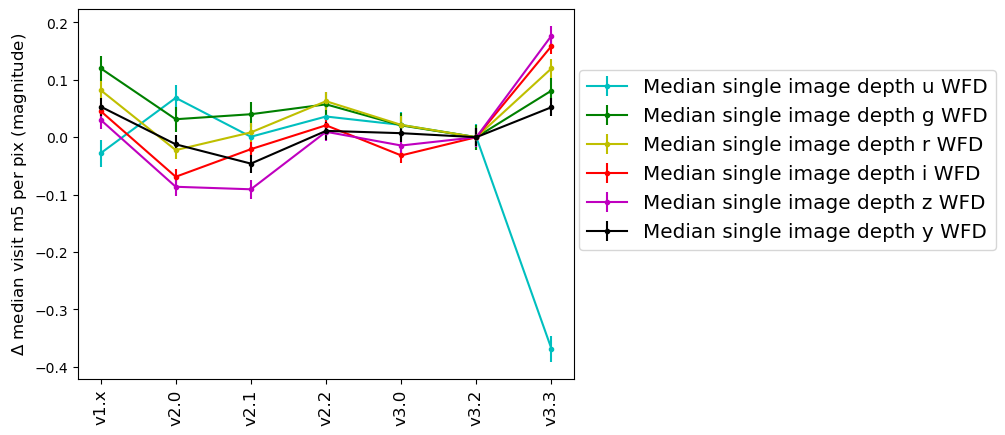

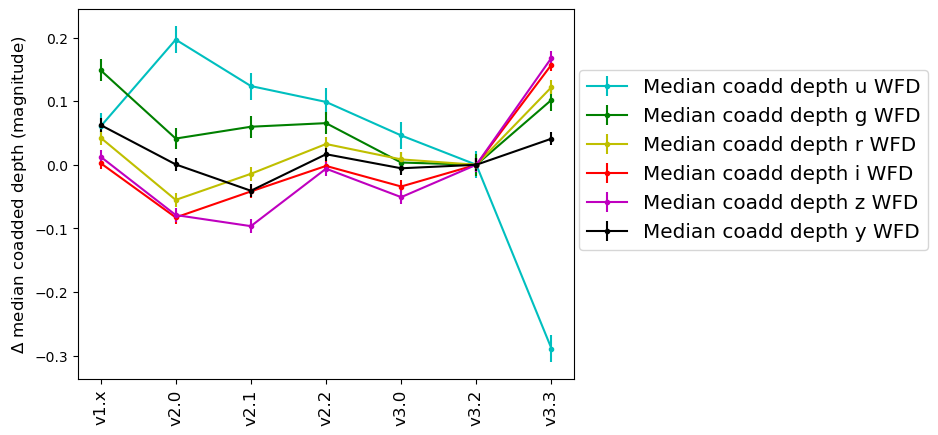

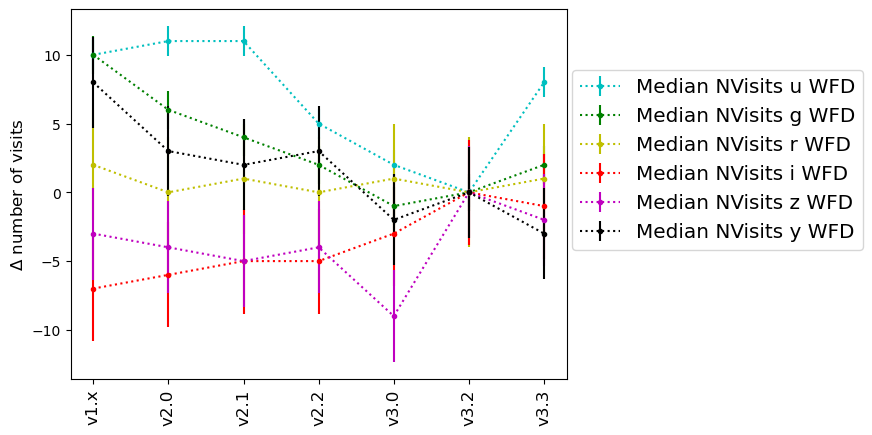

In [23]:
k = 'WFD Depths'
baseline = 'baseline_v3.2_10yrs'

msub = metric_sets.loc[k].query('metric.str.contains("Mean Median")')
fig, ax = plot_metric(summaries.loc[baselines] - summaries.loc[baseline], dev, list(baseline_dict.values()), msub)
ax.set_ylabel("$\Delta$ median visit m5 per pix (magnitude)", fontsize='large')
fig.savefig(os.path.join(outdir, 'visit_m5_per_pix' + '.png'), format='png')


msub = metric_sets.loc[k].query('metric.str.contains("Coadd")')
fig, ax = plot_metric(summaries.loc[baselines] - summaries.loc[baseline], dev, list(baseline_dict.values()), msub)
ax.set_ylabel("$\Delta$ median coadded depth (magnitude)", fontsize='large')
fig.savefig(os.path.join(outdir, 'coadd_m5_per_pix' + '.png'), format='png')

msub = metric_sets.loc[k].query('metric.str.contains("NVisits")')
fig, ax = plot_metric(summaries.loc[baselines] - summaries.loc[baseline], dev, list(baseline_dict.values()), msub)
ax.set_ylabel("$\Delta$ number of visits", fontsize='large')
fig.savefig(os.path.join(outdir, 'nvisit_per_pix'+ '.png'), format='png')

#print(dev[metric_sets.loc[k]['metric']])
summaries.loc[baselines, metric_sets.loc[k]['metric']].T #- summaries.loc[baseline, metric_sets.loc[k]['metric']]

In [24]:
# Verify that the changes in conditions for the visits in u band in baseline_v3.2 and baseline_v3.3 are very similar -- 
# the depth changes come from the throughputs, not how they're acquired
depthcols = [m for m in summaries if "fiveSigmaDepth" in m and 'u band' in m and "UniSlicer" in m
             and ("Mean" in m or "Median" in m or "%ile" in m) and "WFD" in m and "Yr 1" not in m]
airmasscols = [m for m in summaries if "airmass" in m and "u band" in m and "UniSlicer" in m and ("Min" in m or "Mean" in m) and "WFD" in m and "norm" not in m]
seeingcols = [m for m in summaries if "seeingEff" in m and "u band" in m and "UniSlicer" in m and ("Min" in m or "Mean" in m) and "WFD" in m]
skybrightnesscols = [m for m in summaries if "skyBrightness" in m and "u band" in m and "UniSlicer" in m and ("Max" in m or "Mean" in m) and "WFD" in m]
cols = depthcols

metric                     Identity 25th%ile fiveSigmaDepth WFD u band UniSlicer  \
run                                                                                
retro_baseline_v2.0_10yrs                                          23.263614       
baseline_v2.0_10yrs                                                23.381289       
baseline_v2.1_10yrs                                                23.327647       
baseline_v2.2_10yrs                                                23.340661       
baseline_v3.0_10yrs                                                23.331791       
baseline_v3.2_10yrs                                                23.307411       
baseline_v3.3_10yrs                                                22.944207       

metric                     Identity 75th%ile fiveSigmaDepth WFD u band UniSlicer  \
run                                                                                
retro_baseline_v2.0_10yrs                                          23.702547       
baseline_v2.0_10yrs                                                23.837226       
baseline_v2.1_10yrs                                                23.755357       
baseline_v2.2_10yrs                                                23.792290       
baseline_v3.0_10yrs                                                23.781796       
baseline_v3.2_10yrs                                                23.772176       
baseline_v3.3_10yrs                                                23.398972       

metric                     Identity Mean fiveSigmaDepth WFD u band UniSlicer  \
run                                                                            
retro_baseline_v2.0_10yrs                                          23.464129   
baseline_v2.0_10yrs                                                23.593242   
baseline_v2.1_10yrs                                                23.524864   
baseline_v2.2_10yrs                                                23.547127   
baseline_v3.0_10yrs                                                23.536888   
baseline_v3.2_10yrs                                                23.519499   
baseline_v3.3_10yrs                                                23.152536   

metric                     Identity Median fiveSigmaDepth WFD u band UniSlicer  
run                                                                             
retro_baseline_v2.0_10yrs                                          23.501266    
baseline_v2.0_10yrs                                                23.621676    
baseline_v2.1_10yrs                                                23.556964    
baseline_v2.2_10yrs                                                23.583467    
baseline_v3.0_10yrs                                                23.572015    
baseline_v3.2_10yrs                                                23.558201    
baseline_v3.3_10yrs                                                23.183284

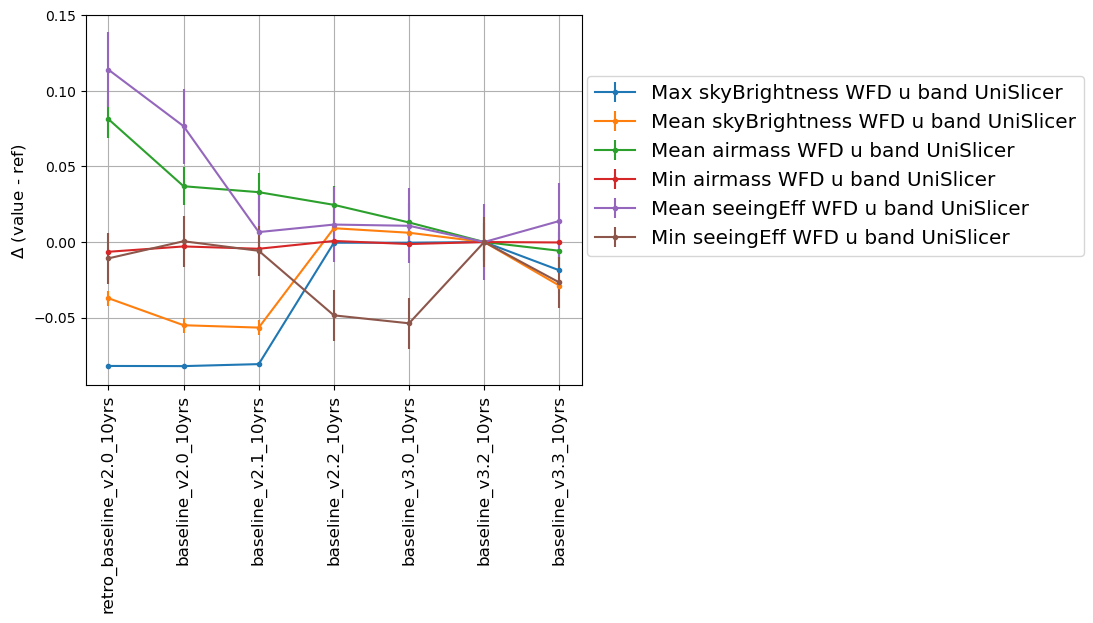

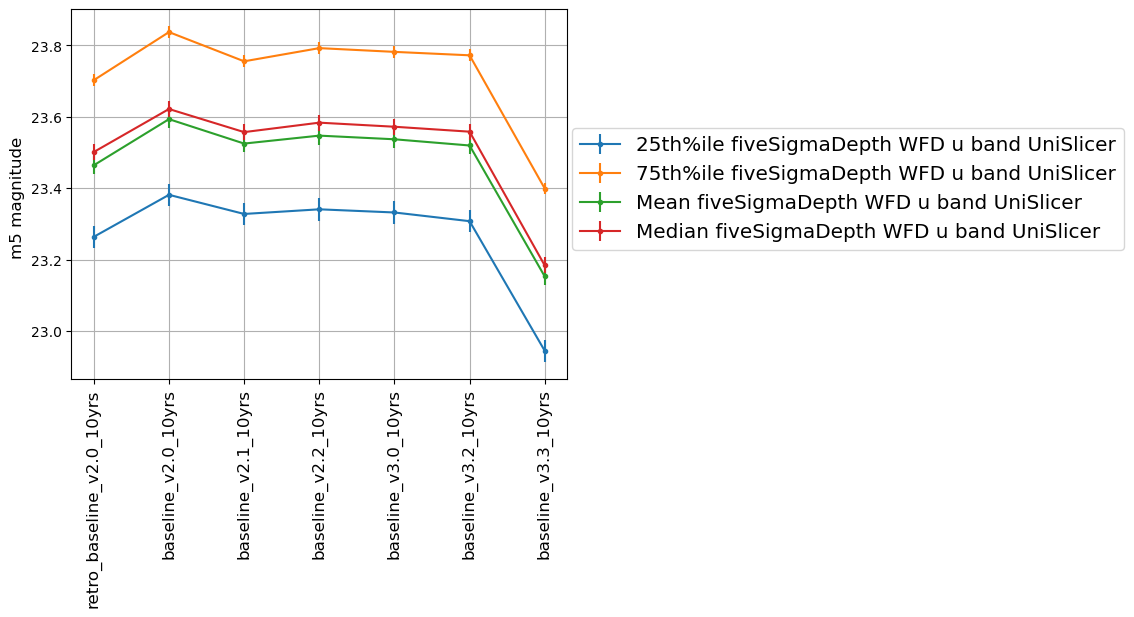

In [25]:
fig = plt.figure()
for cols in [skybrightnesscols, airmasscols, seeingcols]:
    if cols == skybrightnesscols:
        sign = 1
    else:
        sign = -1
    fig, ax = plot_metric((summaries.loc[baselines] - summaries.loc[baseline])*sign, 
                          dev, baselines, cols, fig=fig)
ax.set_ylabel("$\Delta$ (value - ref) ", fontsize='large')
ax.grid()

fig = plt.figure()
for cols in [depthcols]:
    fig, ax = plot_metric(summaries.loc[baselines], # - summaries.loc[baseline], 
                          dev, baselines, cols, fig=fig)
plt.legend(loc=(1.01, 0.35), fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.set_ylabel(f"m5 magnitude ", fontsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'u_m5_per_visit'+ '.png'), format='png')

#print(dev[cols])
summaries.loc[baselines, cols] # - summaries.loc[baseline, cols]

And just check in on the single visit image depth directly, in eah band. Note this is slightly different than the "Mean Median 5sigma depth per image" shown above; this is across all visits, not the median at particular point on the sky. 

run                            v3.2   v3.3
metric                                    
Mean m5 WFD u band per image  23.52  23.15
Mean m5 WFD g band per image  24.29  24.37
Mean m5 WFD r band per image  23.85  23.97
Mean m5 WFD i band per image  23.30  23.46
Mean m5 WFD z band per image  22.69  22.87
Mean m5 WFD y band per image  21.93  21.97

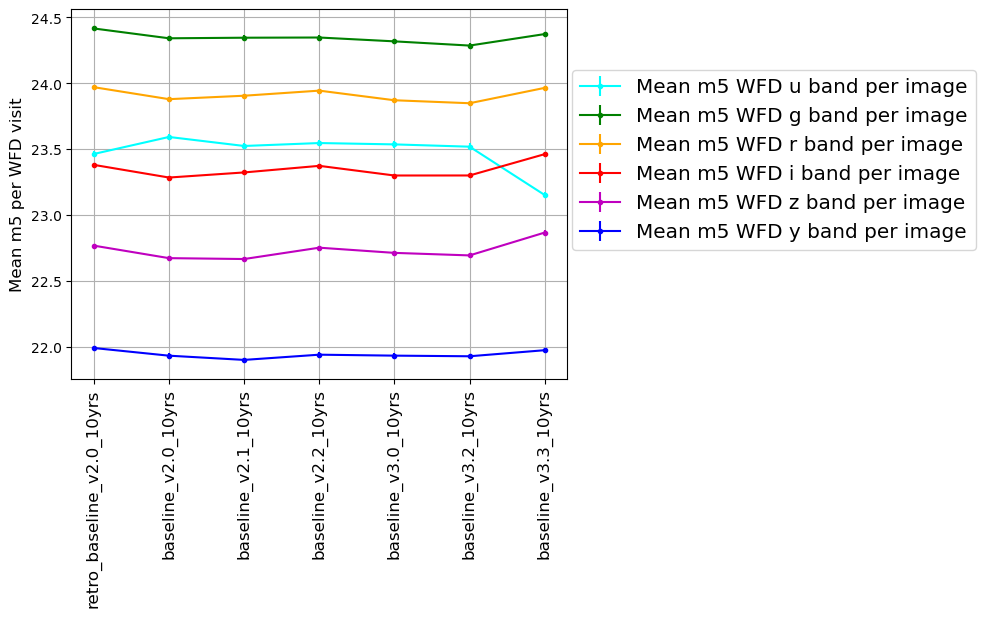

In [26]:
cols = [m for m in summaries if "fiveSigmaDepth" in m and 'band' in m and "UniSlicer" in m
             and ("Mean" in m) and "WFD" in m and "Yr 1" not in m and 'all' not in m]
cols = [f'Identity Mean fiveSigmaDepth WFD {f} band UniSlicer' for f in 'ugrizy']
newcols = [f'Mean m5 WFD {f} band per image' for f in 'ugrizy']

mset = maf.create_metric_set_df('VisitDepths', metrics=cols, short_name=newcols, invert=False, mag=True) 

fig, ax = plt.subplots() 
for f, col, newcol in zip(['u', 'g', 'r', 'i', 'z', 'y'], cols, newcols):
    ax.errorbar(baselines, summaries.loc[baselines, col].values, yerr=dev[col], 
                color=filter_colors[f], marker='.', linestyle='-', label=newcol)
ax.set_ylabel(f"Mean m5 per WFD visit", fontsize='large')
plt.legend(loc=(1.01, 0.35), fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'm5_per_visit'+ '.png'), format='png')

d = (summaries.loc[baselines, cols])[-2:] #- summaries.loc[baseline, cols])[-2:]
d = d.rename(columns=mset.loc['VisitDepths']['short_name']).rename(index={'baseline_v3.2_10yrs': 'v3.2', 'baseline_v3.3_10yrs': 'v3.3'}).round(2)
d.T

We can confirm that these changes are consistent with moving from 1.7 (which is what v3.2 and earlier simulations used) to 1.9 (current, triple Ag) throughput curves. See https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/m5_changes.ipynb

We can also check in on the resulting improvement in survey effective time. We expect it to improve because more visits are acquired in redder bands than in u band, so the efficiency gains in grizy can overcome the loss of depth in u. 

In [27]:
cols = [m for m in summaries if "Teff All sky all bands" in m and "UniSlicer" in m and "Normalized" not in m]
cols

d = summaries.loc[baselines, cols]/summaries.loc[baseline, cols]
d = d.rename(columns={'Identity Total Teff All sky all bands UniSlicer': "Teff Total"})
d.round(2)[-2:]

metric               Teff Total
run                            
baseline_v3.2_10yrs        1.00
baseline_v3.3_10yrs        1.21

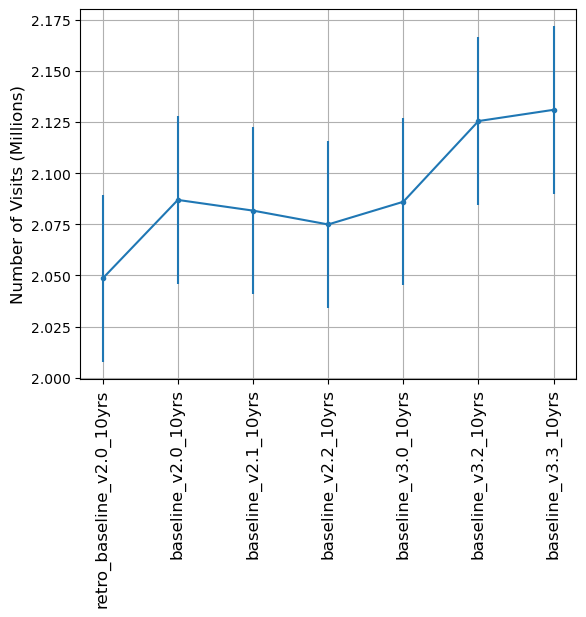

In [28]:
# How did the overall number of visits change for each simulation baseline?  Note some simulations include more shorter visits, and this will be reflected in these numbers.

cols = [m for m in summaries if "Nvisits" in m and "UniSlicer" in m and 'All' in m]
cols

fig, ax = plt.subplots() 
for col in cols:
    ax.errorbar(baselines, summaries.loc[baselines, col].values/1e6, yerr=dev[col]/1e6, 
                marker='.', linestyle='-', label="Number of Visits")
ax.set_ylabel(f"Number of Visits (Millions)", fontsize='large')
#plt.legend(loc=(1.01, 0.35), fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'total_nvisits'+ '.png'), format='png')

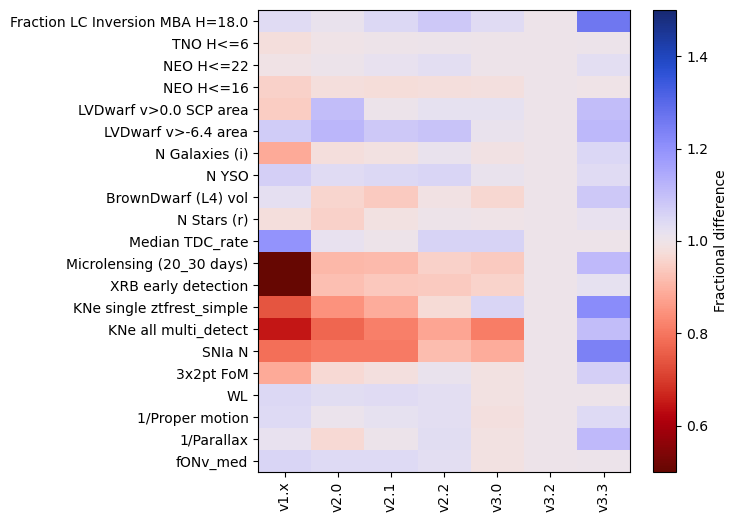

In [29]:
# What about the SCOC high-level overview? 

msub = metric_sets.loc['SCOC']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[baselines, msub['metric']], 
                     baseline_run=baseline,
                     metric_set=msub,
                        metric_label_map=msub['short_name'],
                        run_label_map=baseline_dict)
fig.savefig(os.path.join(outdir, 'scoc_grid'+ '.png'), format='png')

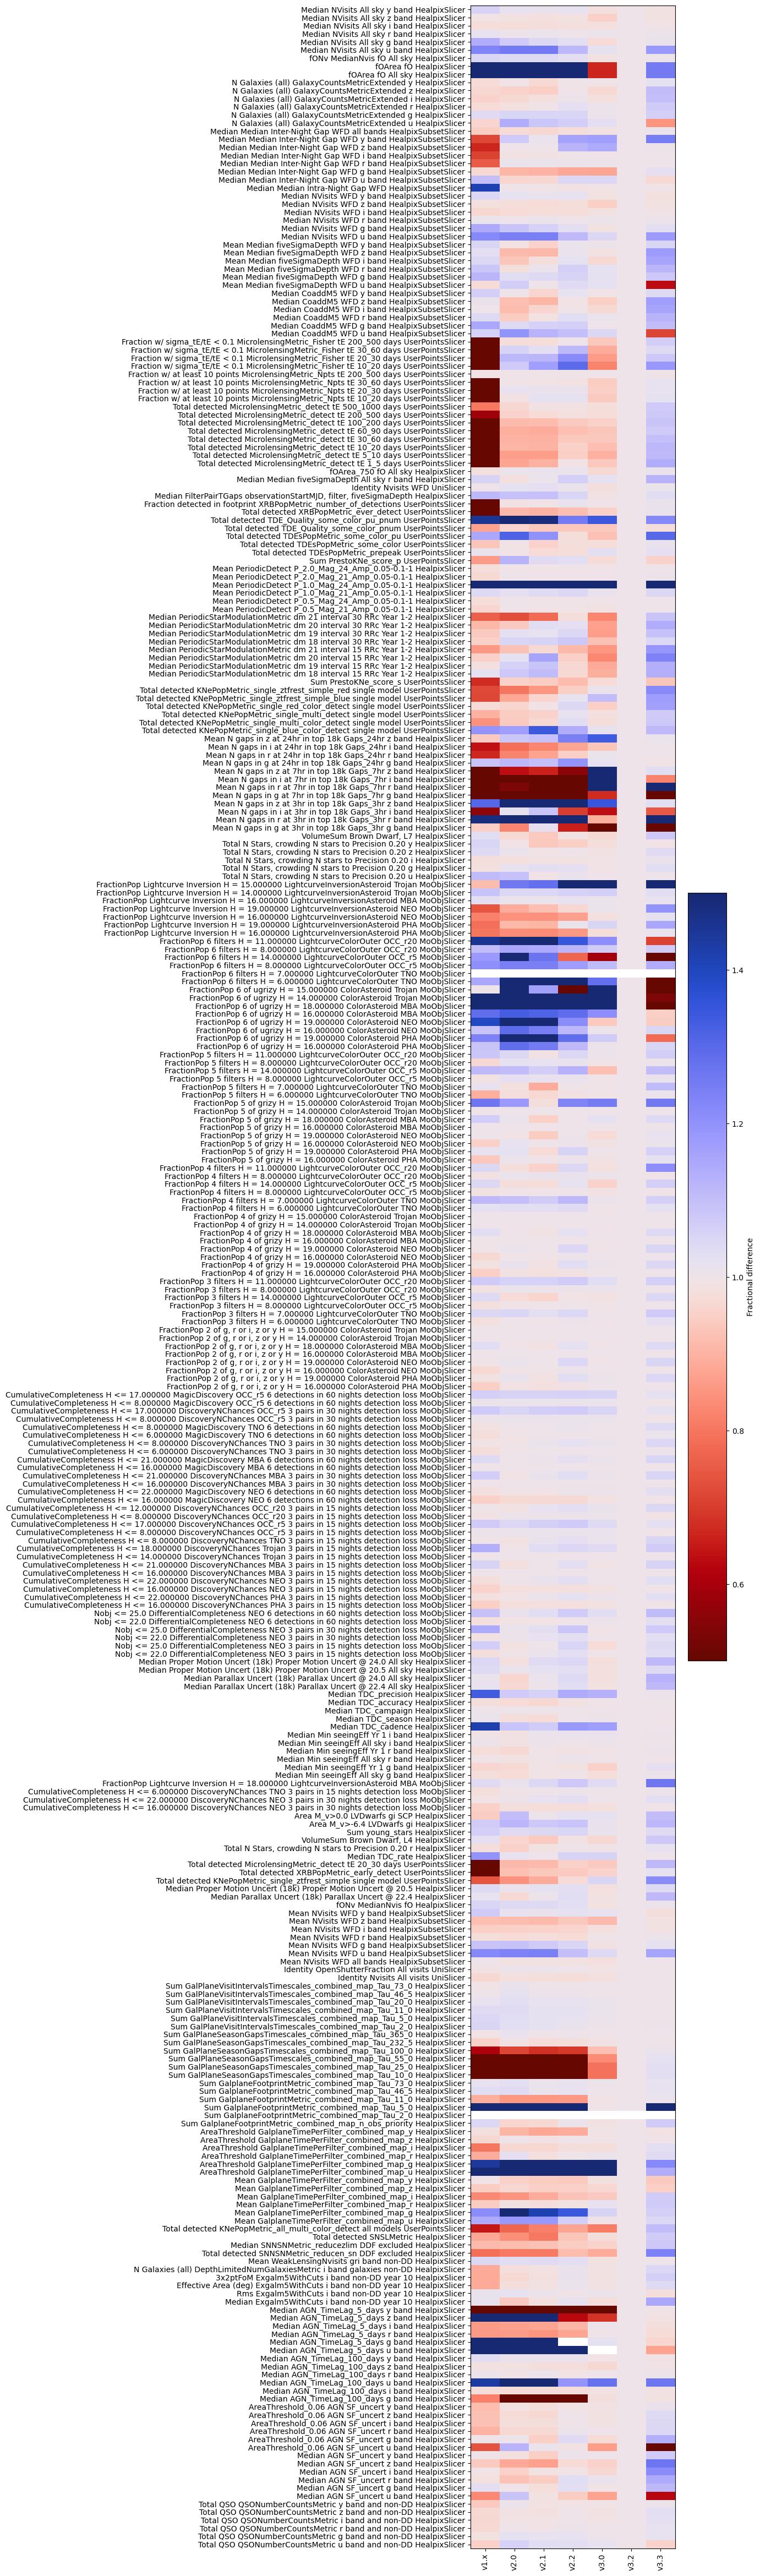

In [30]:
# Plot allll the metrics
non_dd = [m for m in msets if 'DD' not in m]
msub = metric_sets.loc[non_dd].reset_index(drop=True).drop('style', axis=1).drop('short_name', axis=1)
msub = msub.drop_duplicates().set_index('metric', drop=False, verify_integrity=True)

fig, ax = maf.plot_run_metric_mesh(summaries.loc[baselines, msub['metric']], 
                     baseline_run=baseline,
                     metric_set=msub,
                        #metric_label_map=msub['short_name'],
                        run_label_map=baseline_dict)
#fig.set_figwidth(24)
fig.set_figheight(60)
fig.savefig(os.path.join(outdir, 'all_grid'+ '.png'), format='png')

Now we look at the metrics results for subsets of metrics, looking in more depth (which allows us to include error bars which come from the standard deviation of the metric results in the weather runs.

### <a id="SRD">SRD</a>

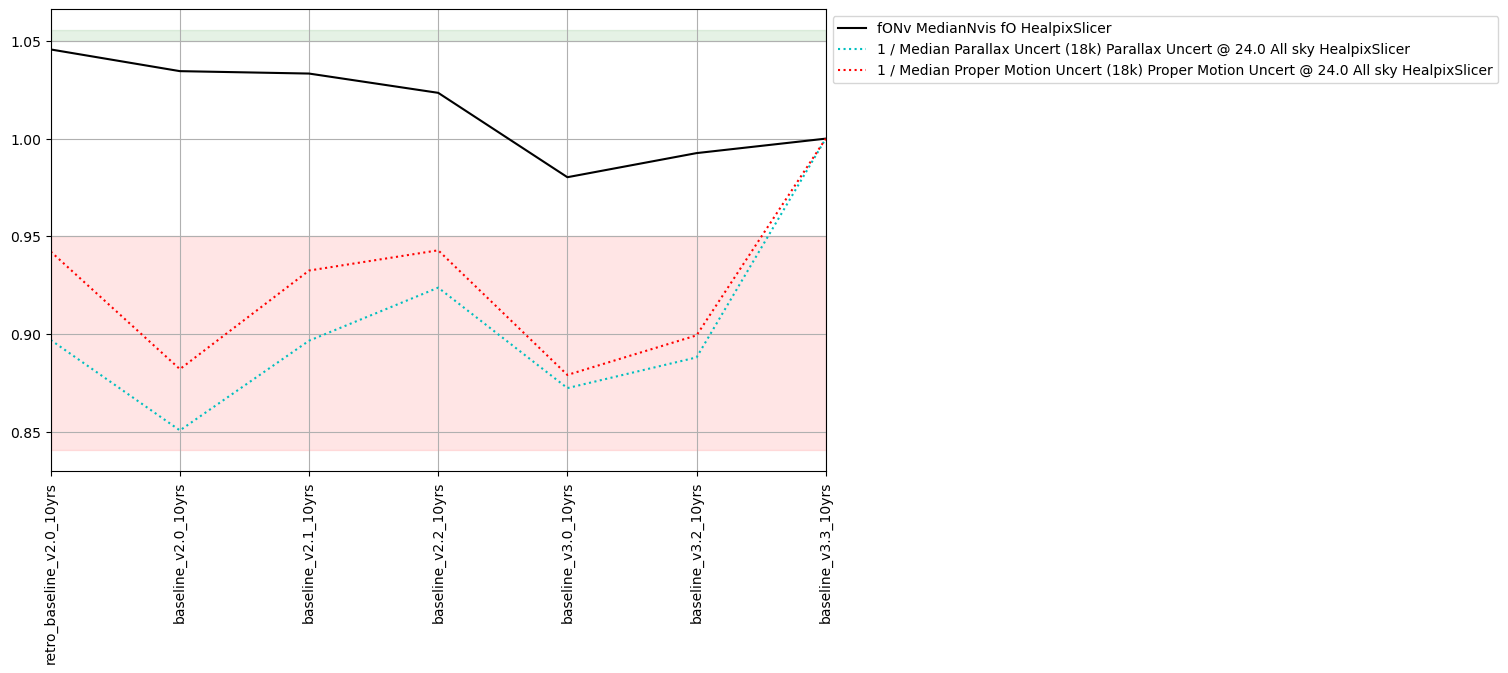

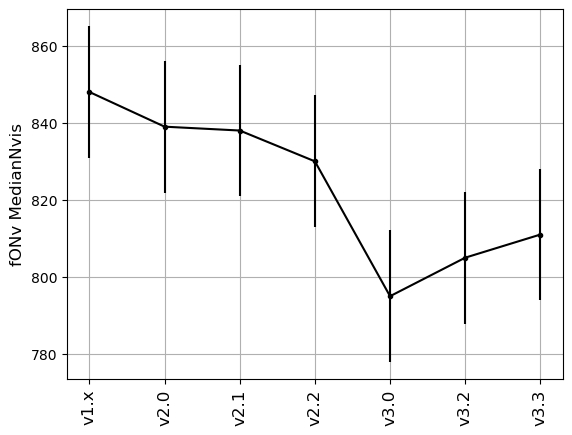

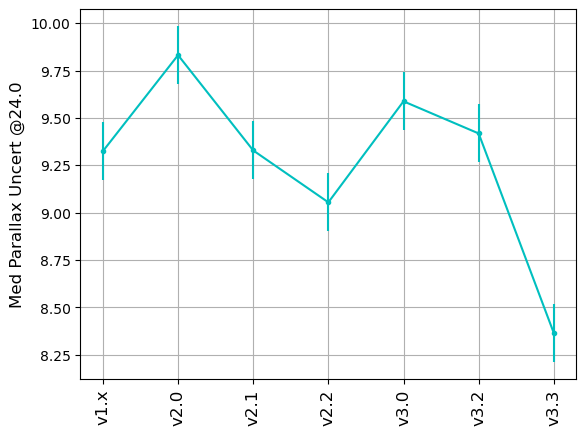

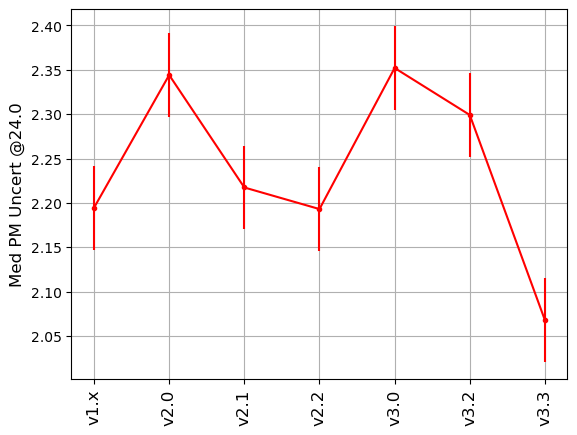

In [33]:
msub = metric_sets.loc['SRD'][::2]  # drop the PM and Parallax at bright mags

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### <a id="SSO">SSO</a>

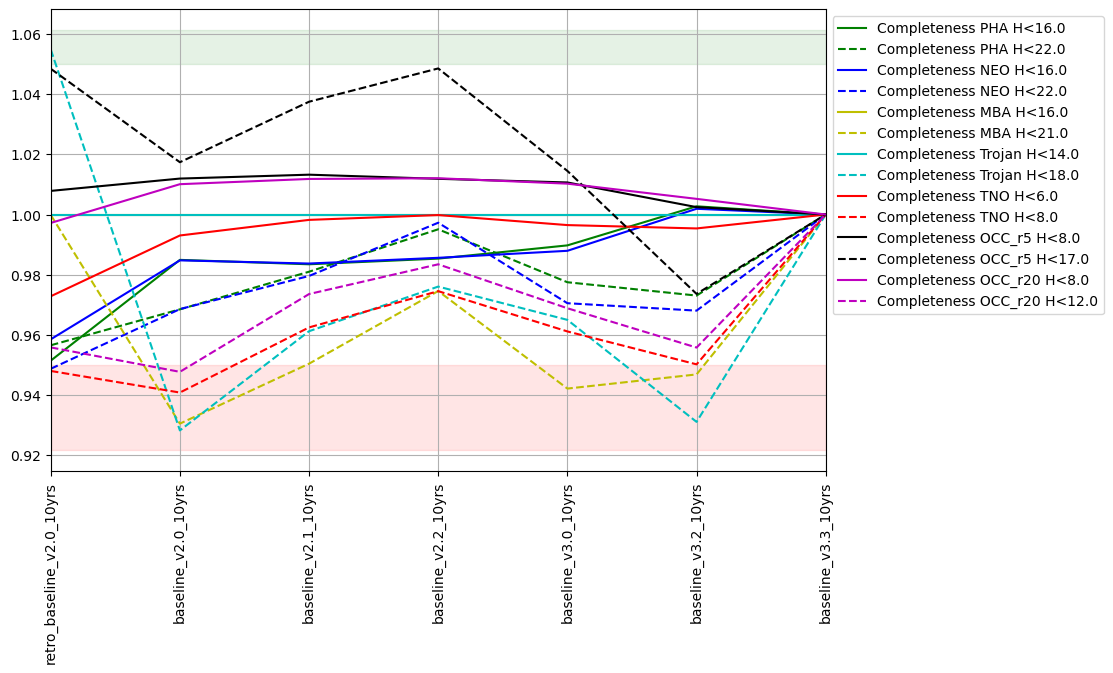

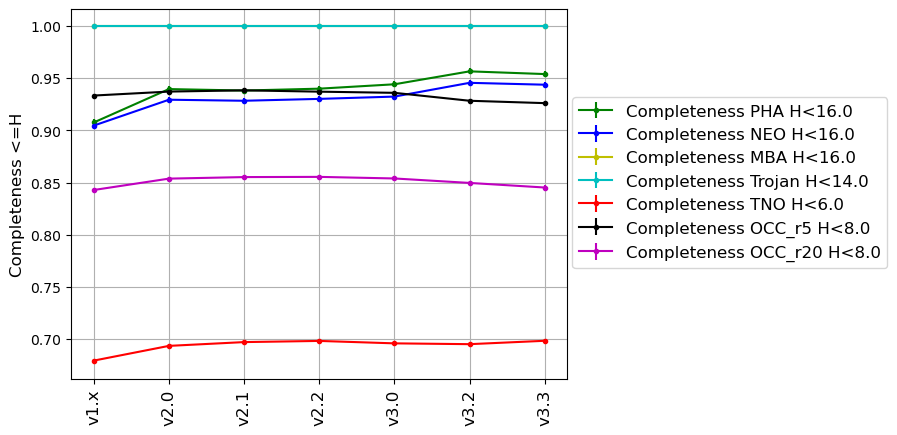

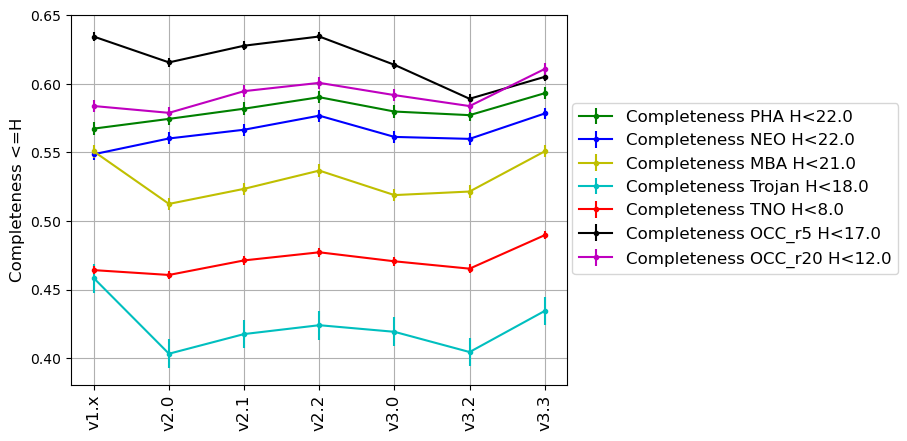

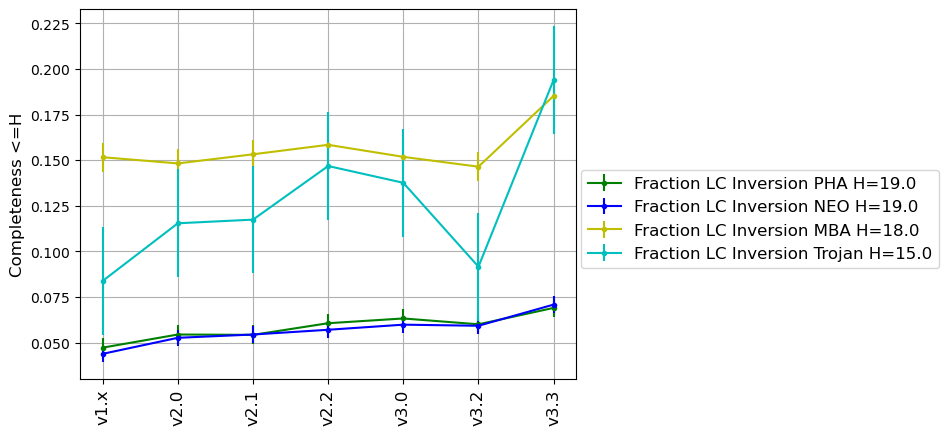

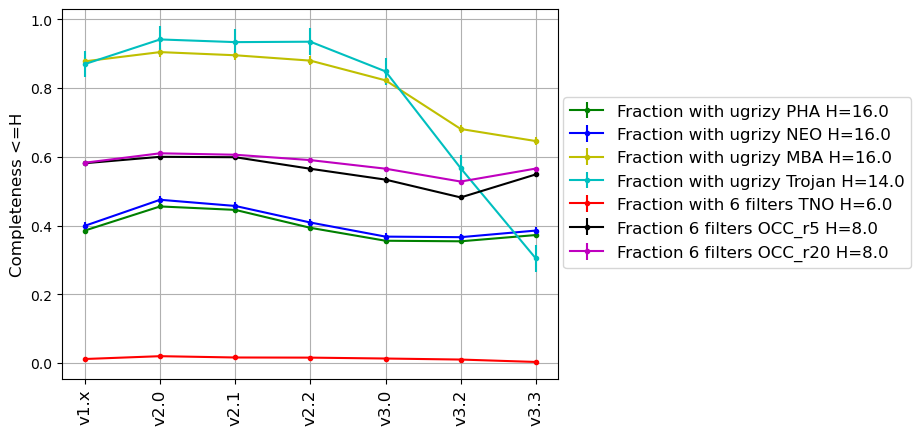

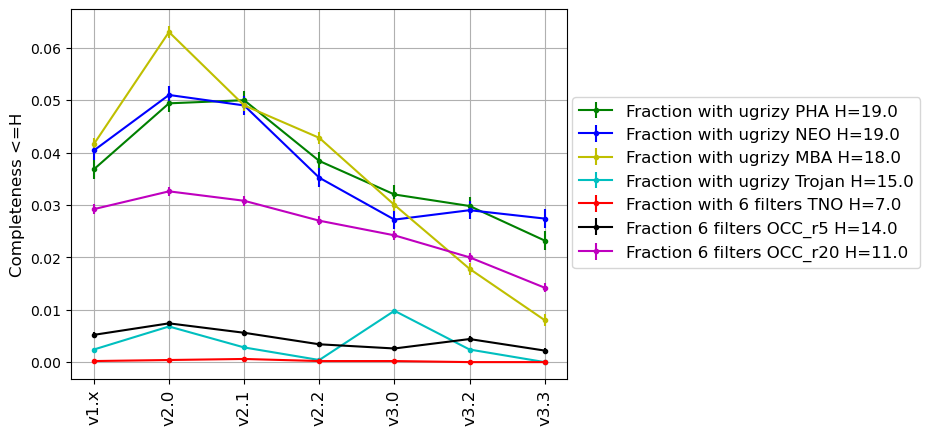

In [34]:
## SSO ##

msub = metric_sets.loc['SSO discovery']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

msub = metric_sets.loc['SSO discovery'][::2]

fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'completeness_bright' + '.png'), format='png')

msub = metric_sets.loc['SSO discovery'][1::2]

fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'completeness_faint' + '.png'), format='png')

msub = metric_sets.loc['SSO lightcurve inversion'][1::2]
fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'lightcurves_faint' + '.png'), format='png')

msub = metric_sets.loc['SSO fraction 6 bands'][::2]
fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'colors6_bright' + '.png'), format='png')

msub = metric_sets.loc['SSO fraction 6 bands'][1::2]
fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'colors6_faint' + '.png'), format='png')

### <a id="DESC WFD">DESC WFD</a>

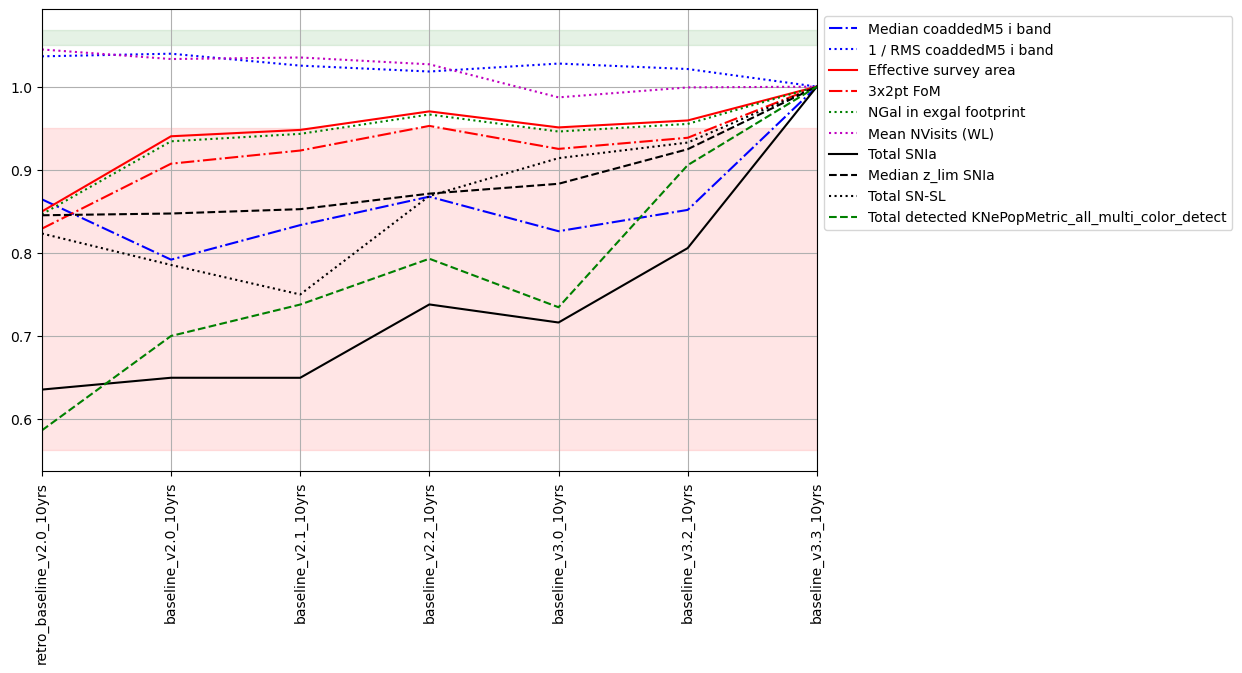

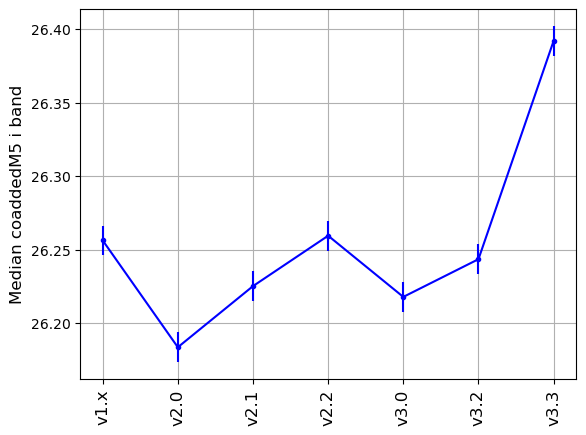

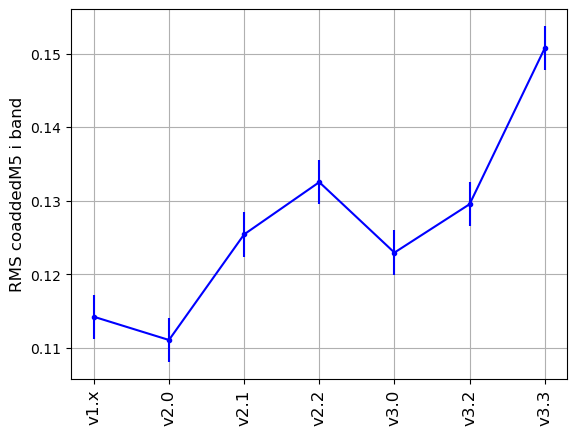

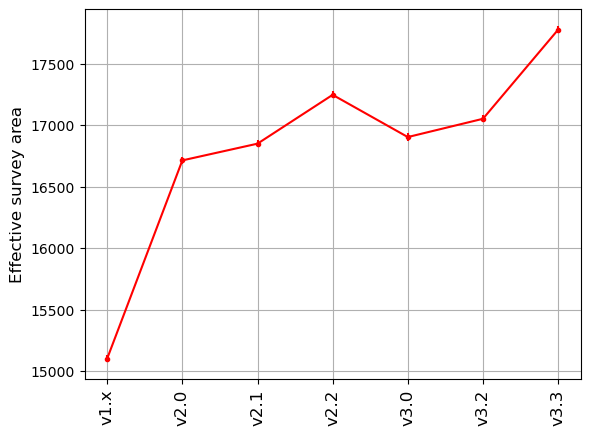

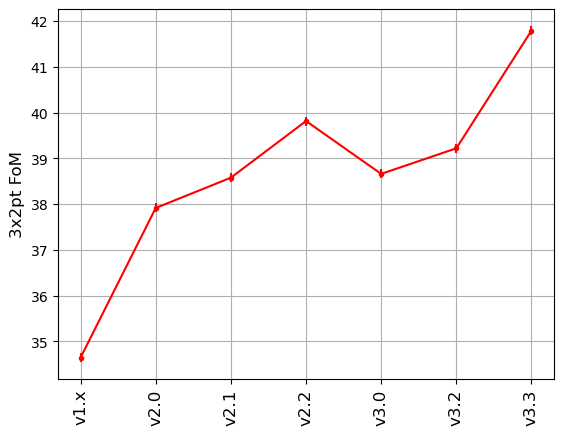

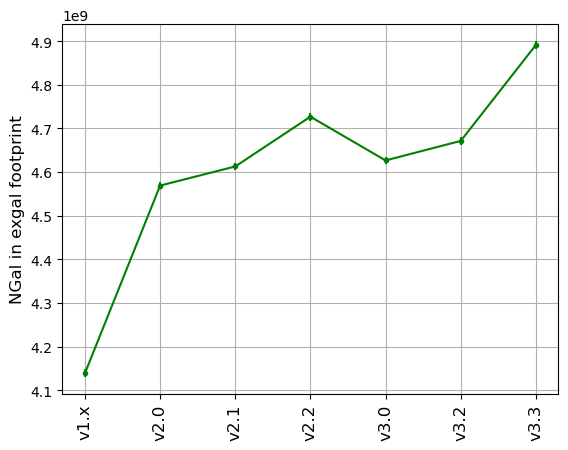

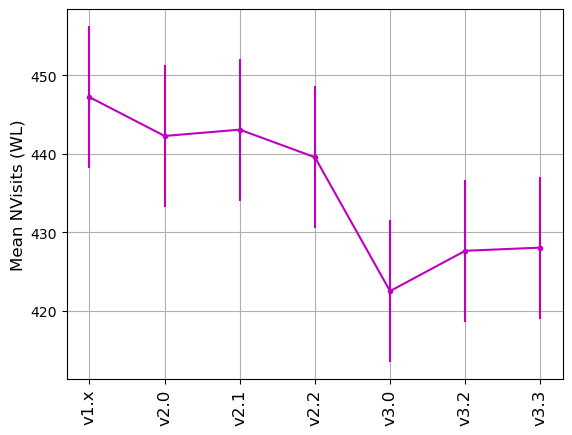

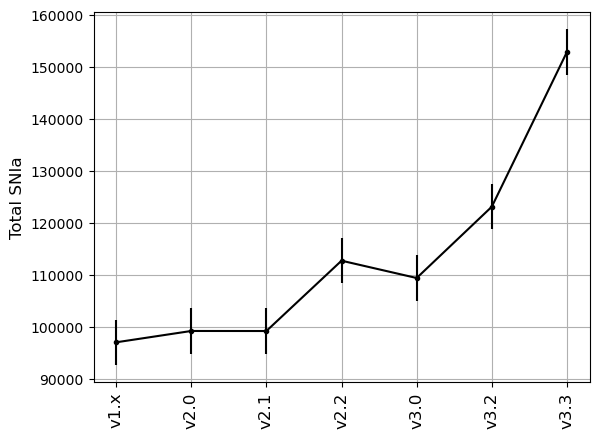

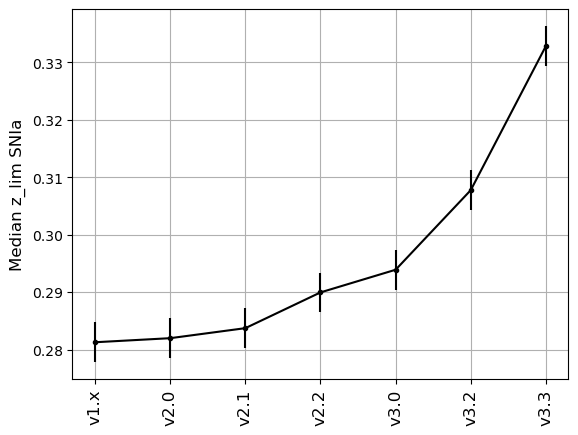

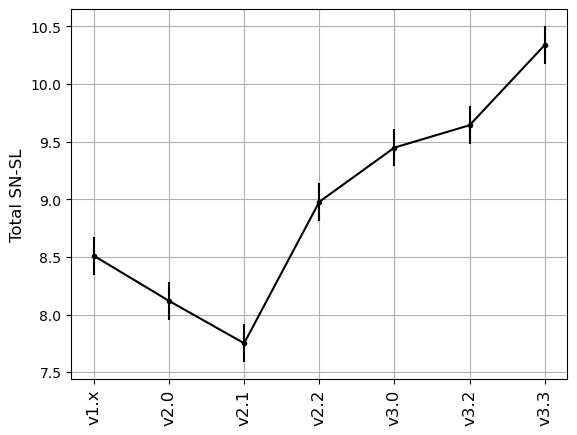

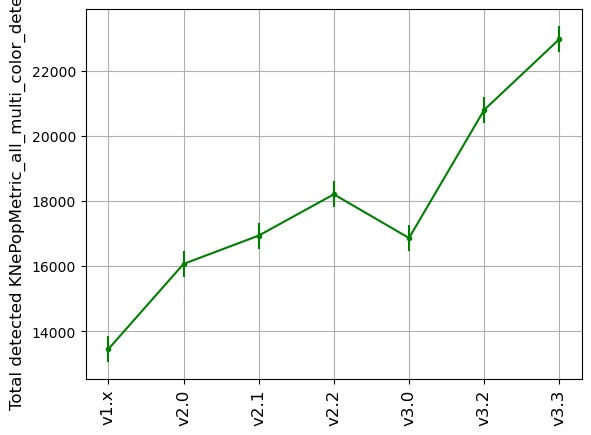

In [35]:
## DESC WFD ## 

msub = metric_sets.loc['DESC WFD']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

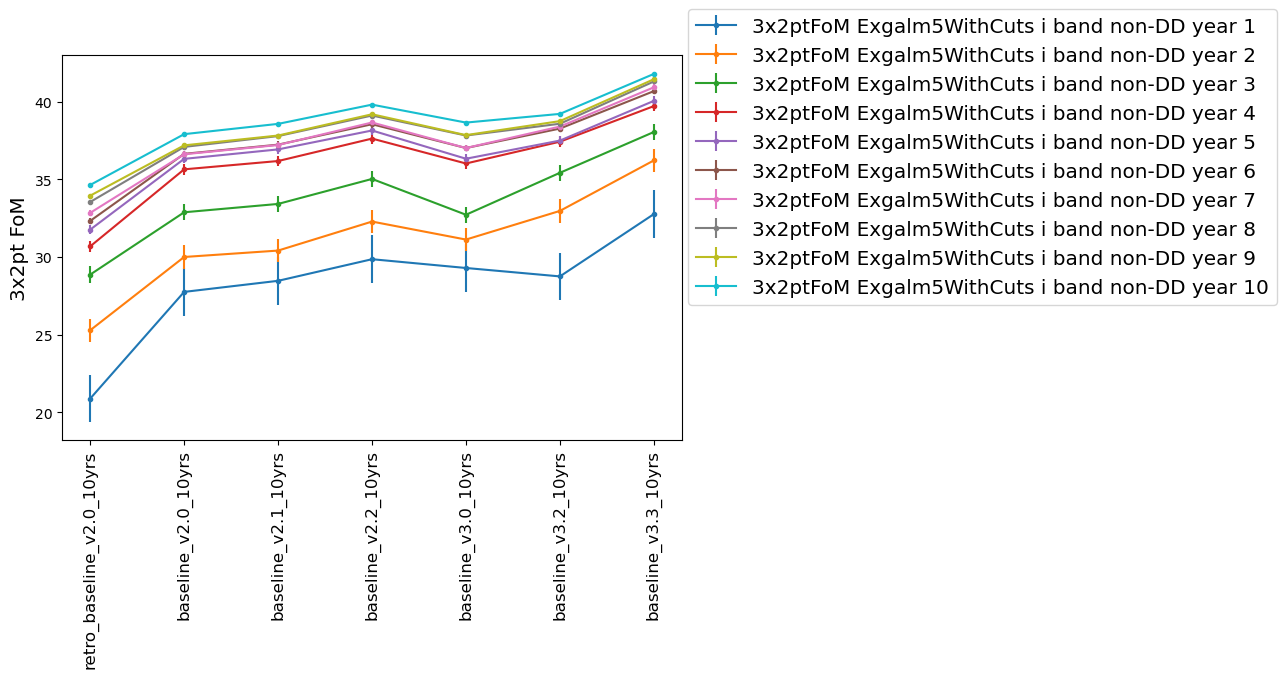

In [36]:
m1 = []
for yr in range(1, 11):
    m1 += [f'3x2ptFoM Exgalm5WithCuts i band non-DD year {yr} HealpixSlicer']

msub = maf.create_metric_set_df('3x2pt', 
                                metrics=m1, 
                                short_name=[m.replace(' HealpixSlicer', '') for m in m1],
                                style='-',
                               )

fig, ax = plot_metric(summaries.loc[baselines], dev, baselines, msub=msub.loc['3x2pt'])
ax.set_ylabel("3x2pt FoM", fontsize='x-large')
fig.set_figwidth(8)
fig.set_figheight(5)


### <a id="TVS">TVS</a>

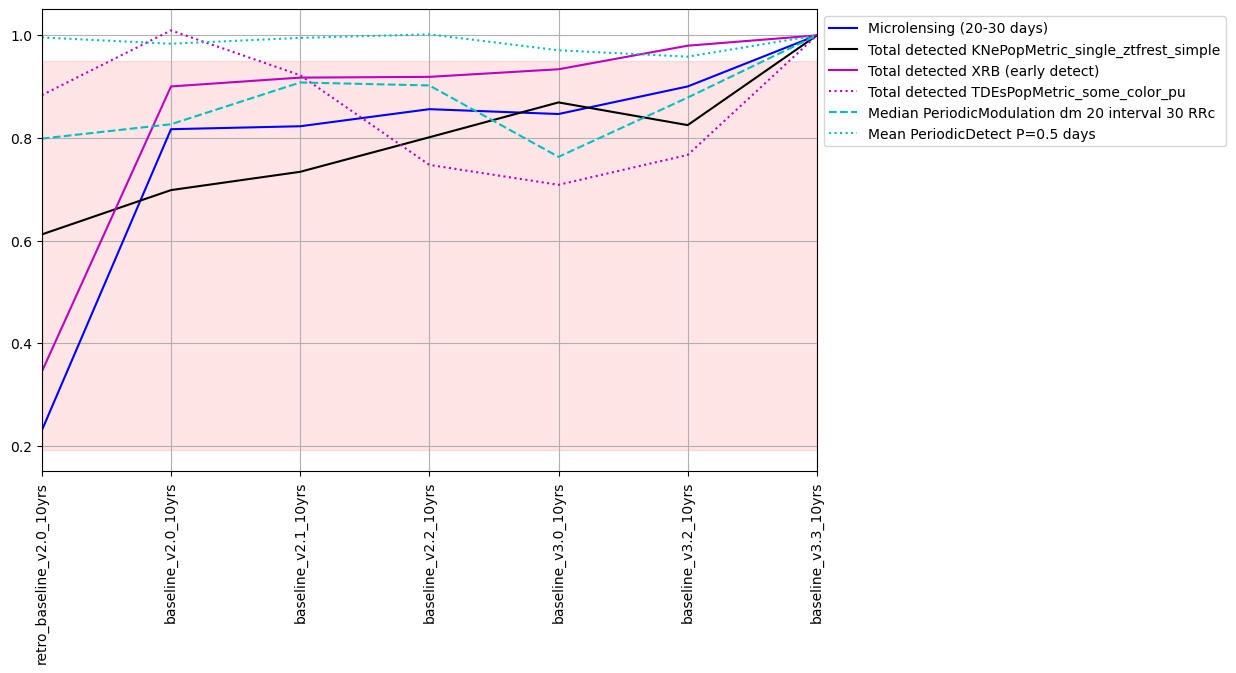

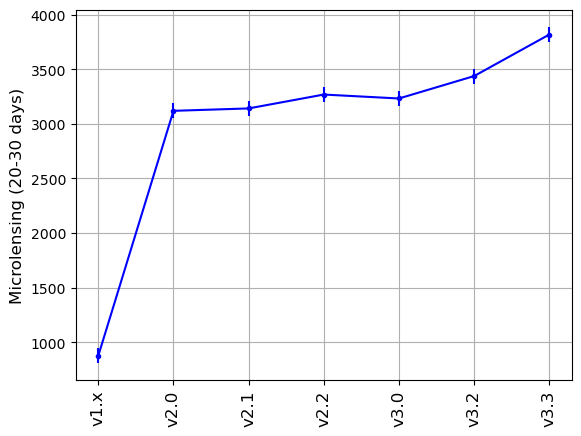

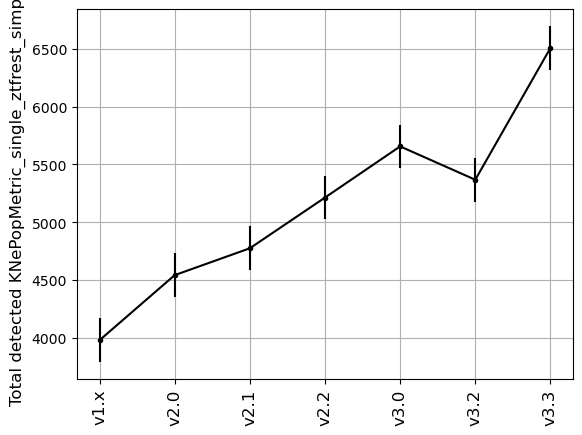

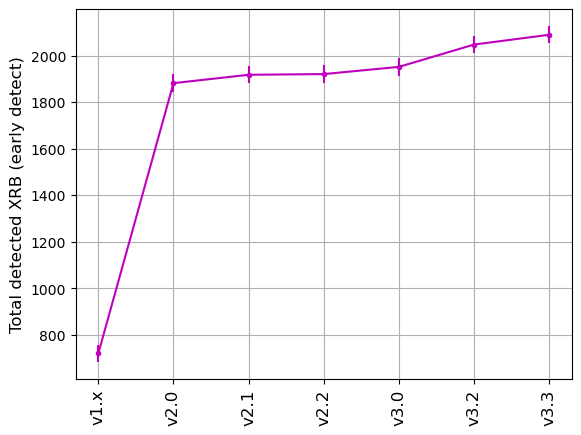

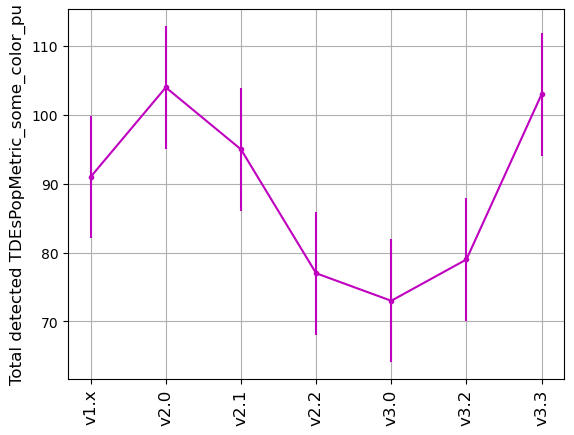

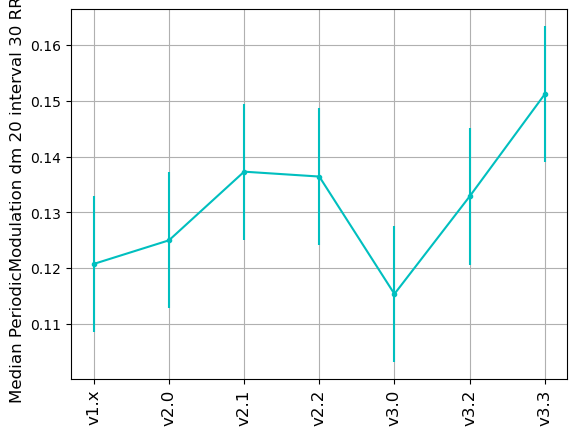

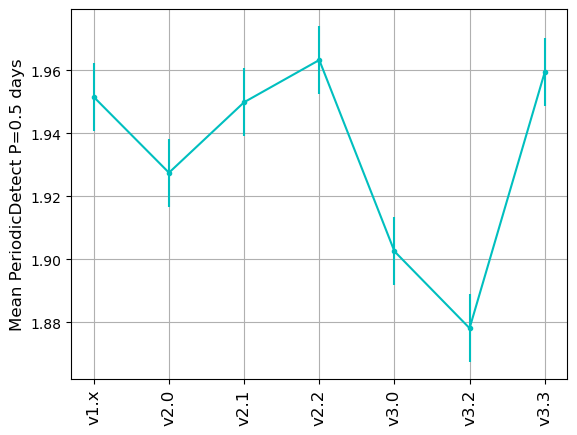

In [37]:
msub = metric_sets.loc['TVS short']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

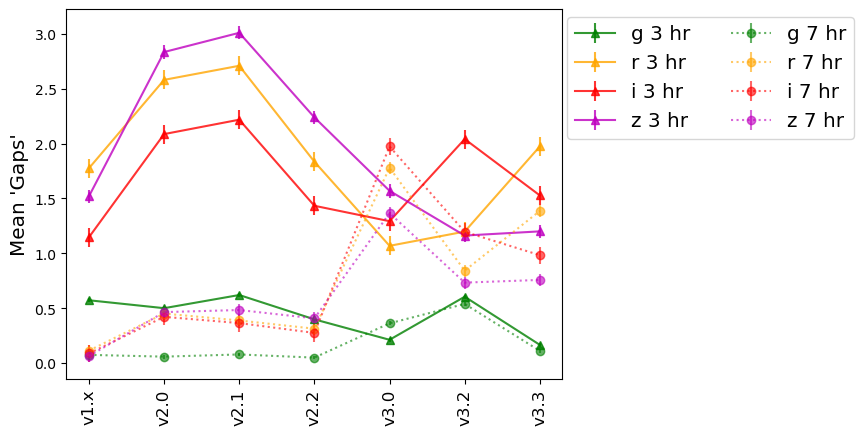

In [38]:
# Time Gaps metric 

fig, ax = plt.subplots()
mset = metric_sets.loc['TVS Gaps'][0:-4]


markers = ['o', 's', '*', '<', '^', 'v', '*', '>', '.', 'X']
j = 0
for i, mm in mset.iterrows():
    m = mm['metric']
    ff = mm['short_name'].split('in ')[-1].split(' at')[0]
    #marker= markers[j]
    marker = 'o'
    if '3' in m:
        marker = '^'
        linestyle='-'
        alpha=0.8
        label=f"{ff} 3 hr"
    if '7' in m:
        marker = 'o'
        linestyle=':'
        alpha=0.6
        label =f"{ff} 7 hr"
    j += 1
    ax.errorbar(baseline_dict.values(), summaries.loc[baselines, m], yerr=dev[m], 
                color=filter_colors[ff], alpha=alpha, marker=marker, linestyle=linestyle, label=label)
plt.legend(loc=(1.01, 0.65), fontsize='x-large', ncols=2)
ax.set_ylabel("Mean 'Gaps'", fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
fig.savefig(os.path.join(outdir, 'tgaps' + '.png'), format='png')

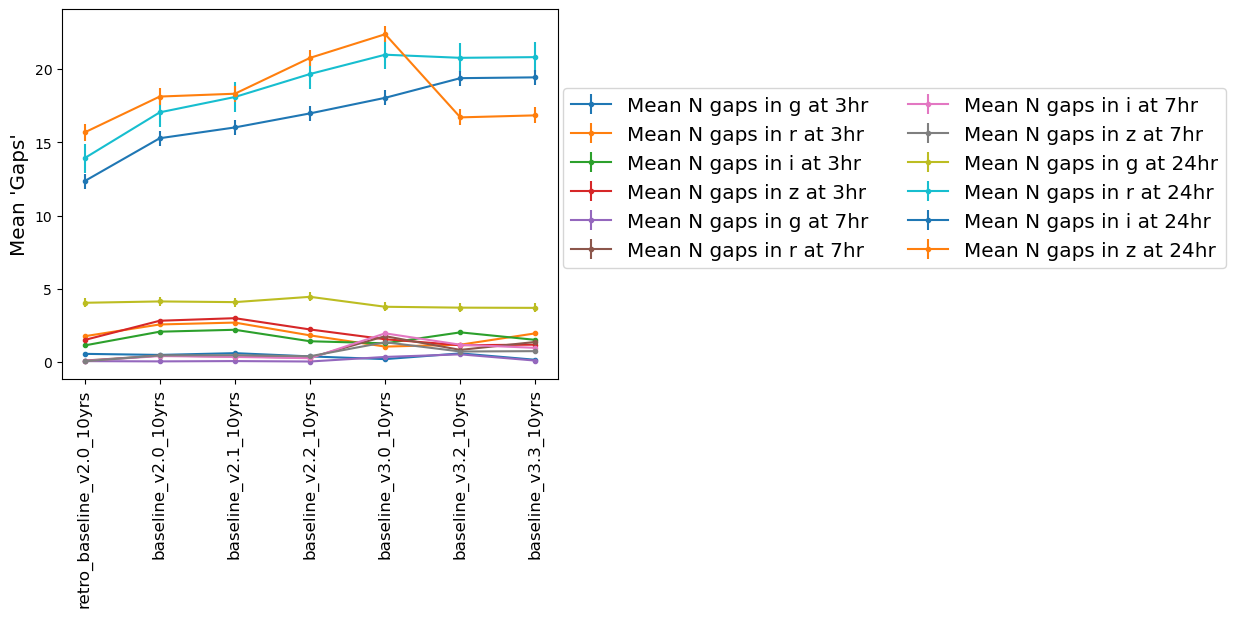

In [39]:
mset = metric_sets.loc['TVS Gaps']

fig, ax = plot_metric(summaries.loc[baselines], dev, baselines, msub=mset)
plt.legend(loc=(1.01, 0.3), fontsize='x-large', ncols=2)
ax.set_ylabel("Mean 'Gaps'", fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')

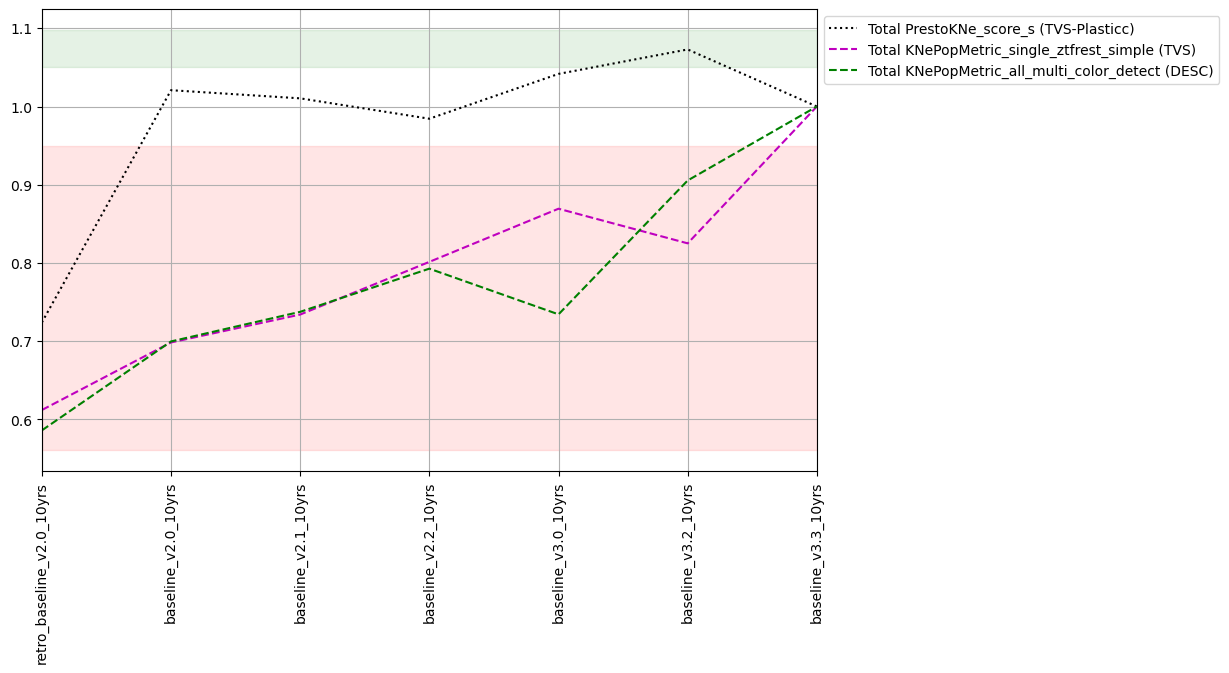

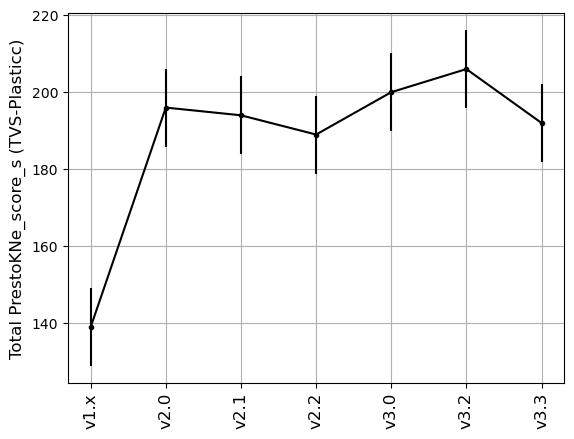

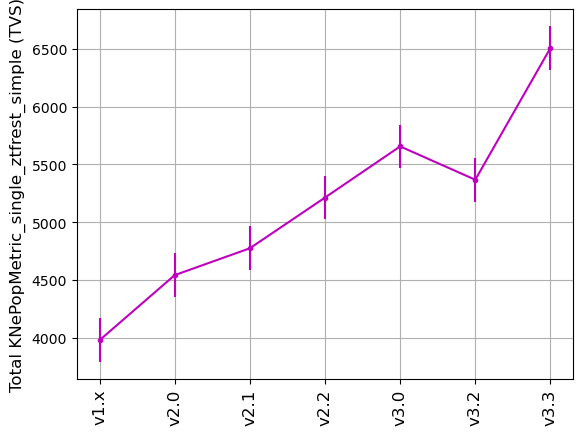

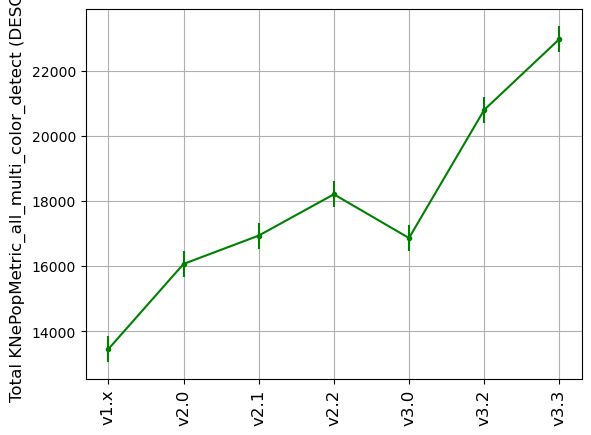

In [40]:
msub = metric_sets.loc['TVS KNe short']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

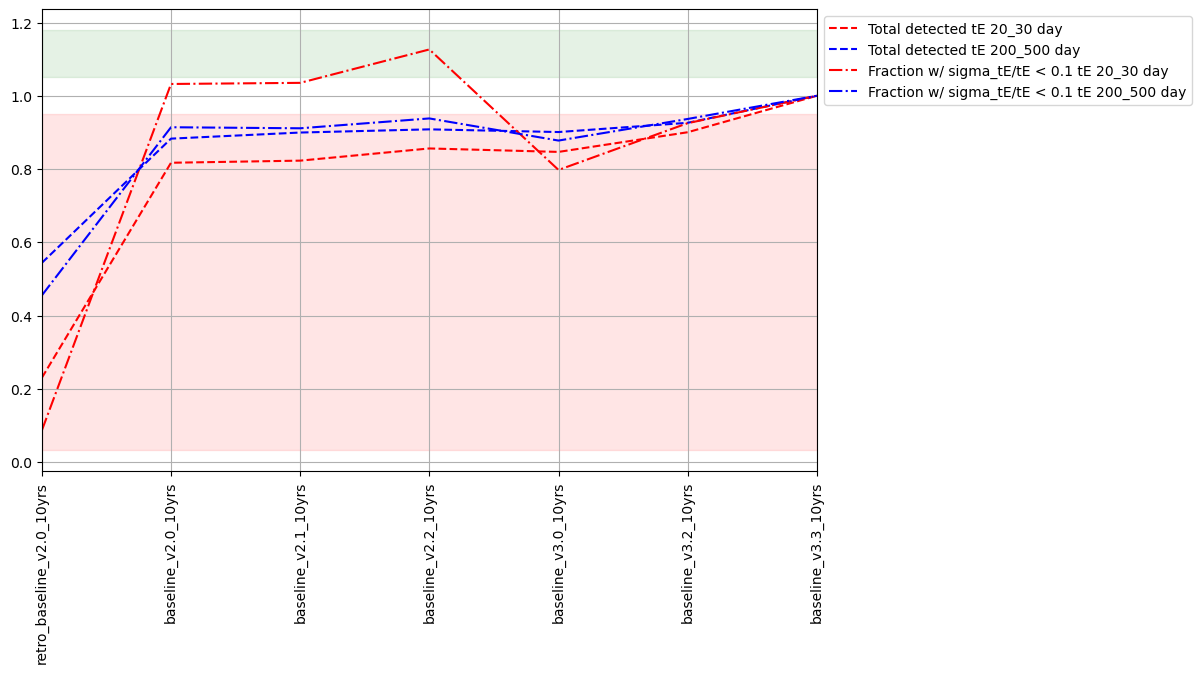

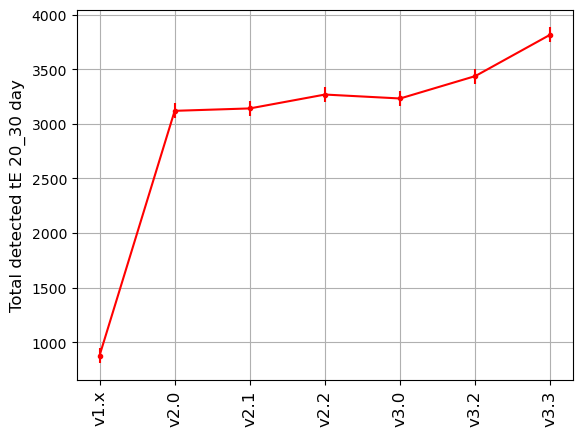

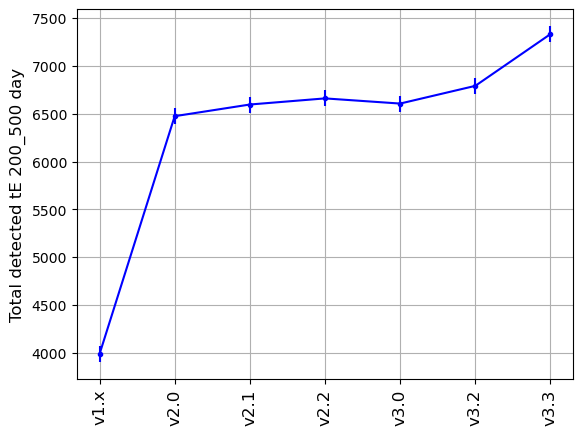

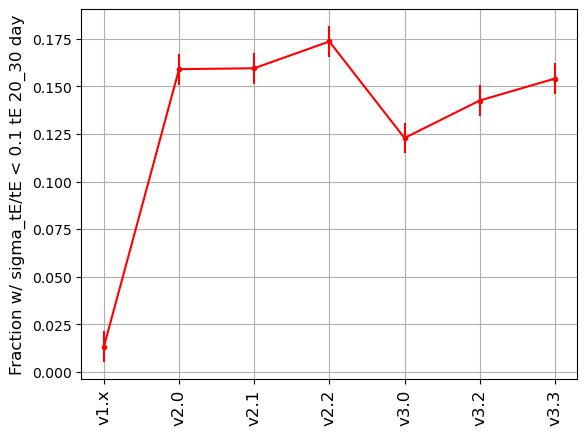

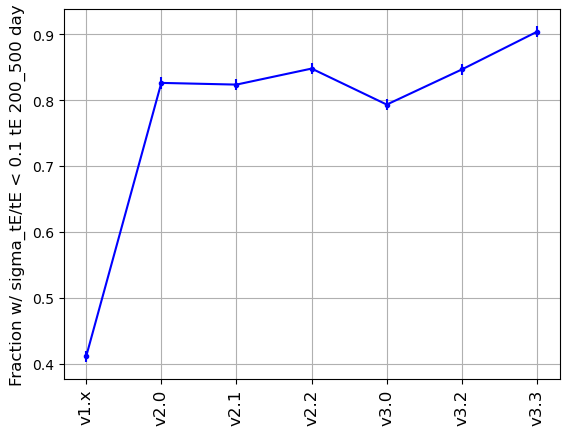

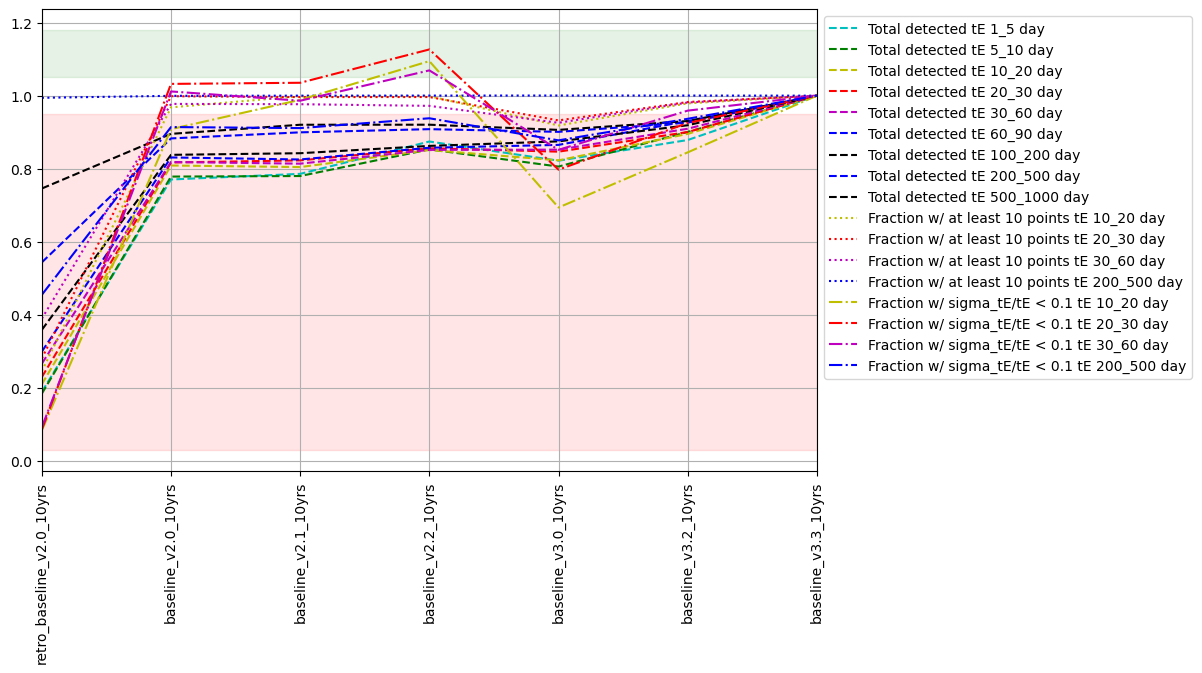

In [41]:
msub = metric_sets.loc['TVS microlensing short']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    #fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

msub = metric_sets.loc['TVS microlensing all']
fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

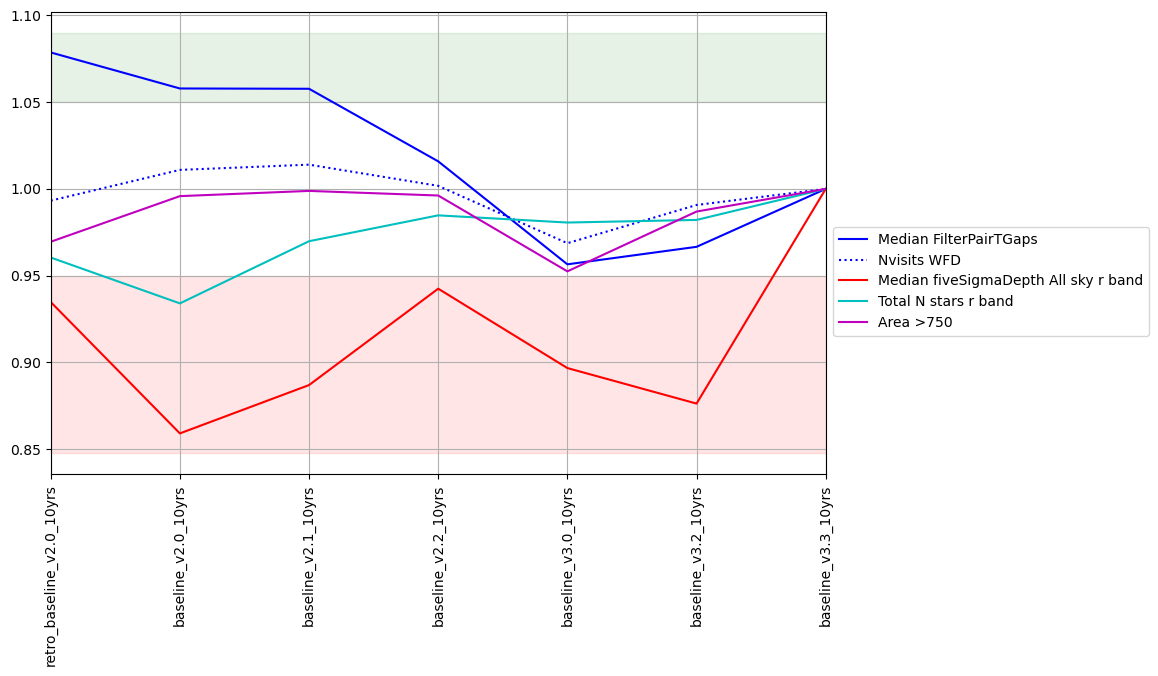

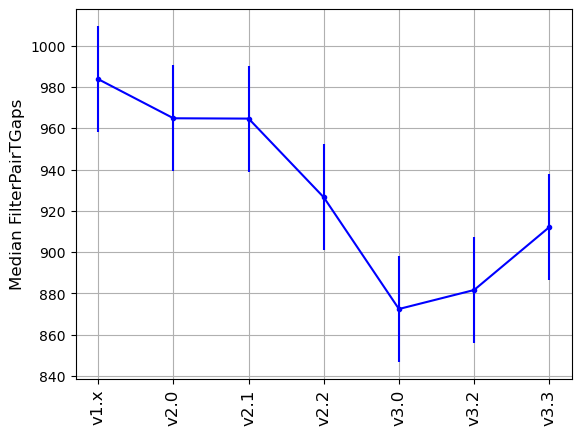

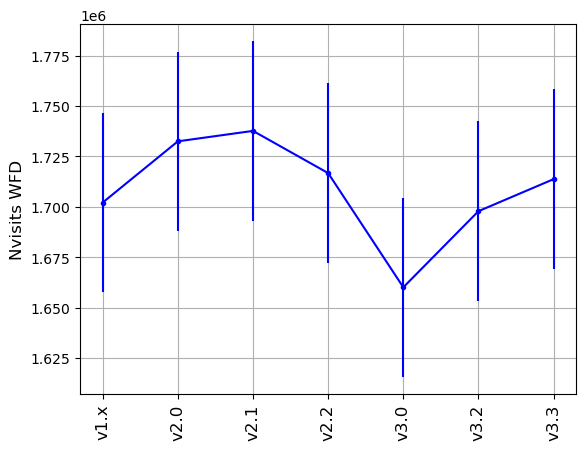

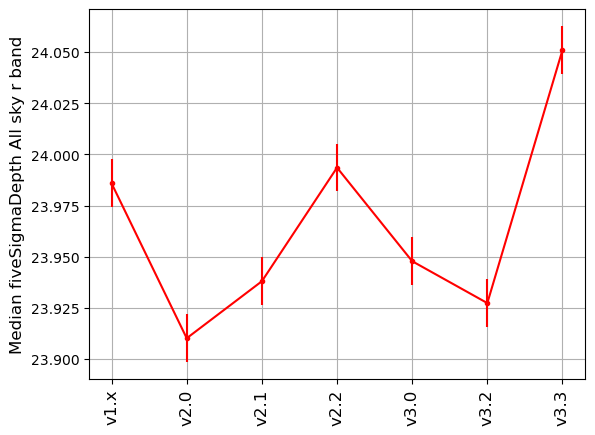

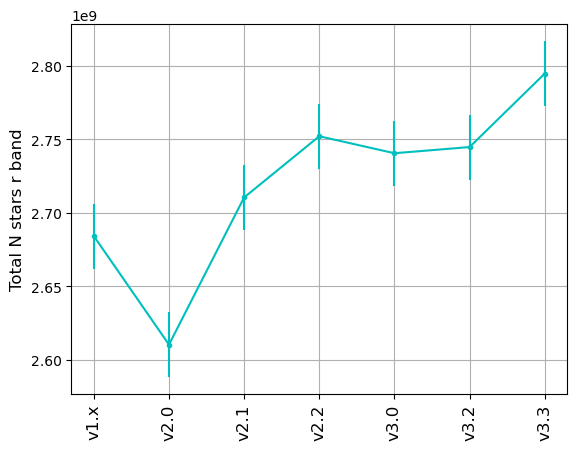

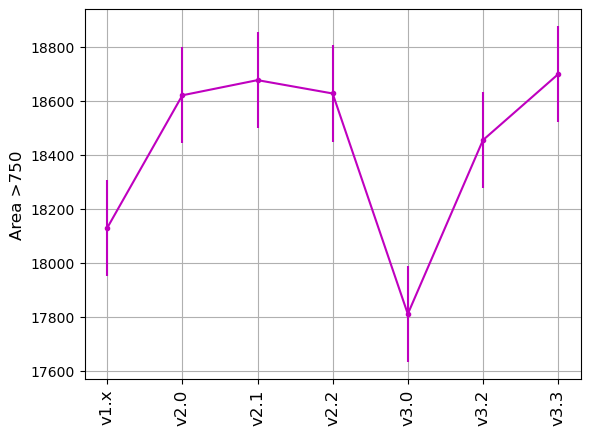

In [42]:
msub = metric_sets.loc['TVS anomalies']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')
ax.legend(loc=(1.01, 0.3))
              
for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### <a id="AGN">AGN</a>

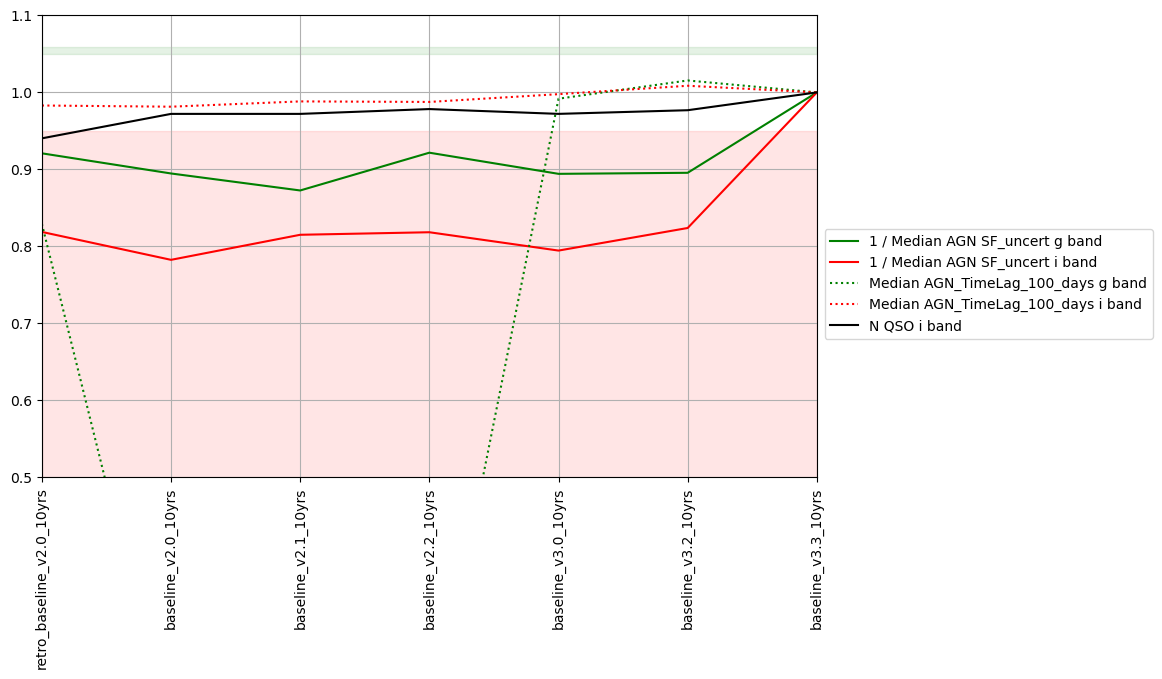

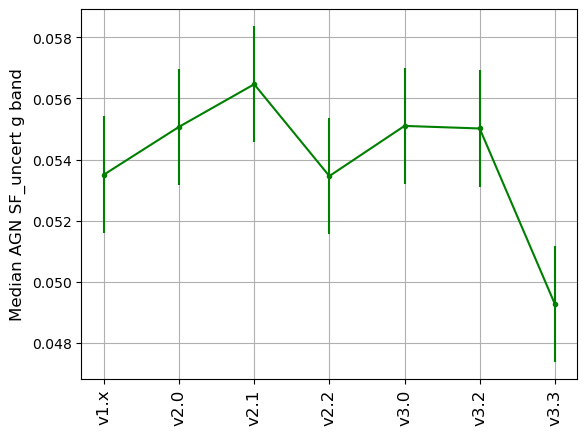

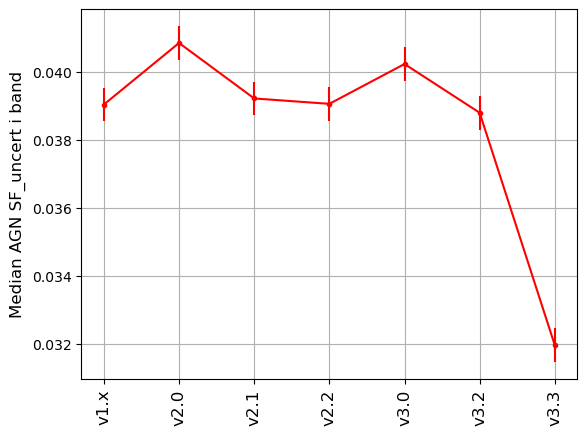

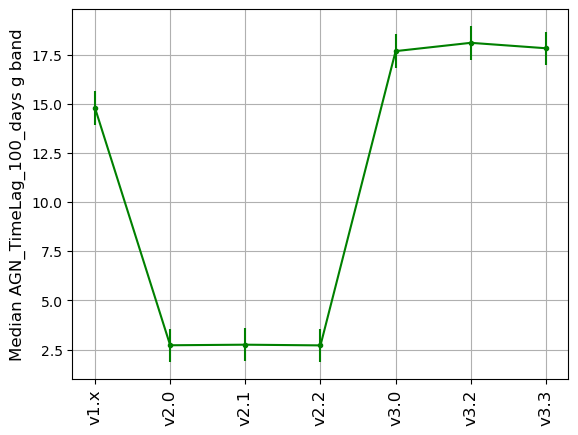

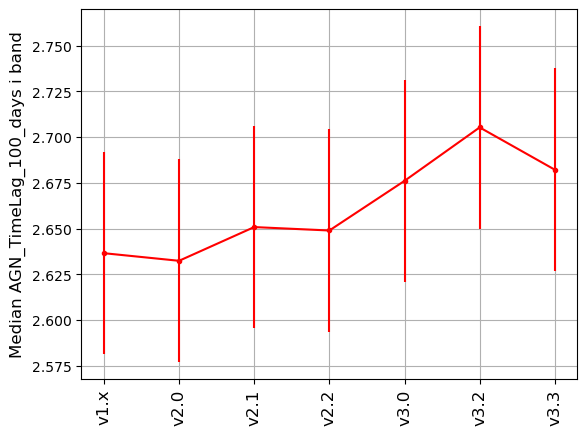

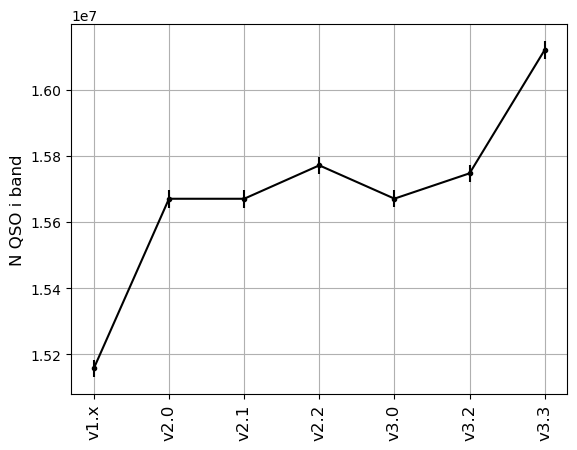

In [43]:
msub = metric_sets.loc['AGN short']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')
ax.legend(loc=(1.01, 0.3))
ax.set_ylim(0.5, 1.1)
              
for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### <a id="Galaxies">Galaxies</a>

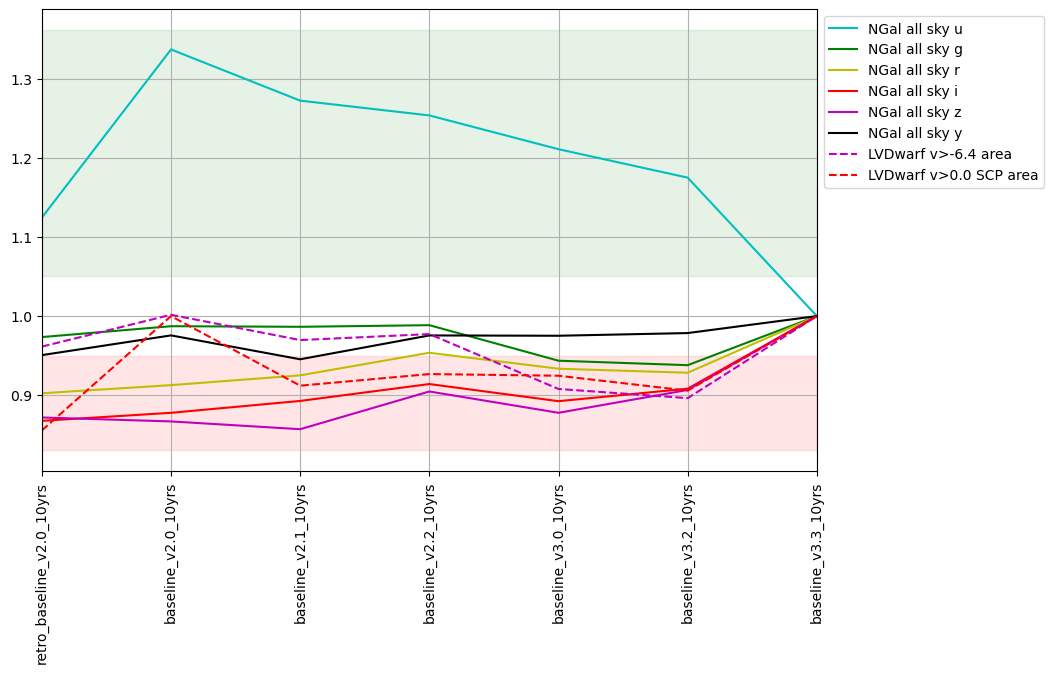

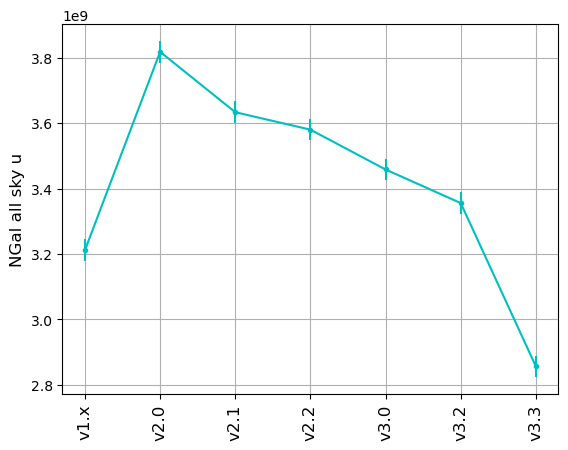

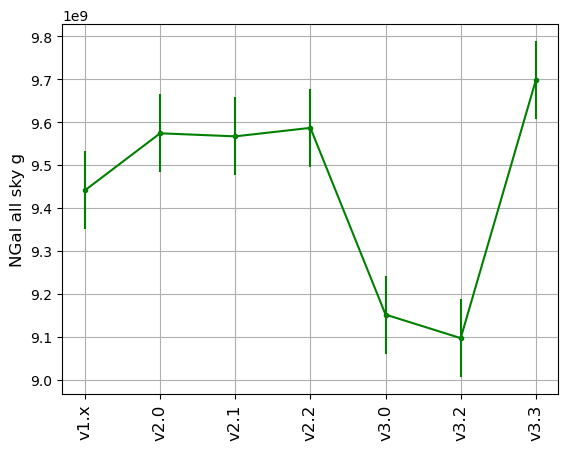

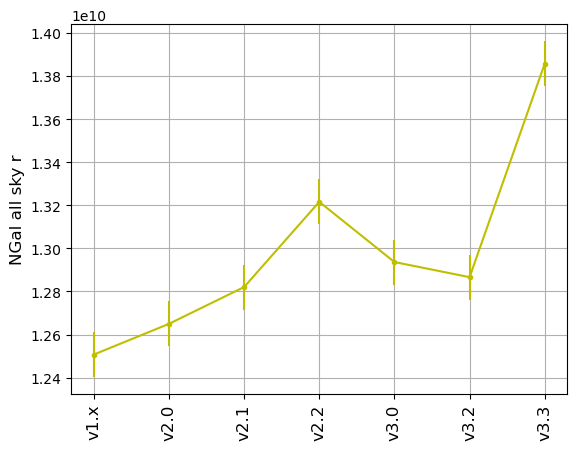

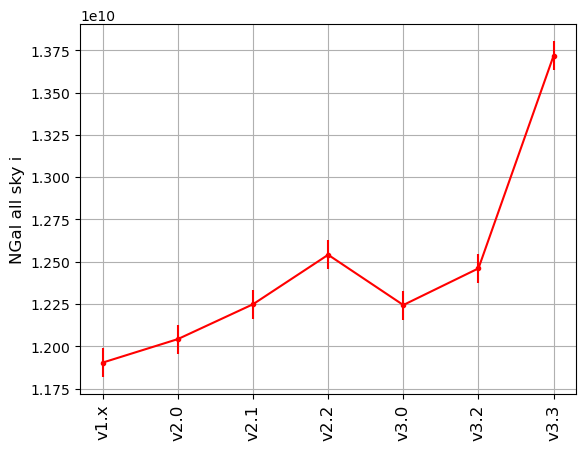

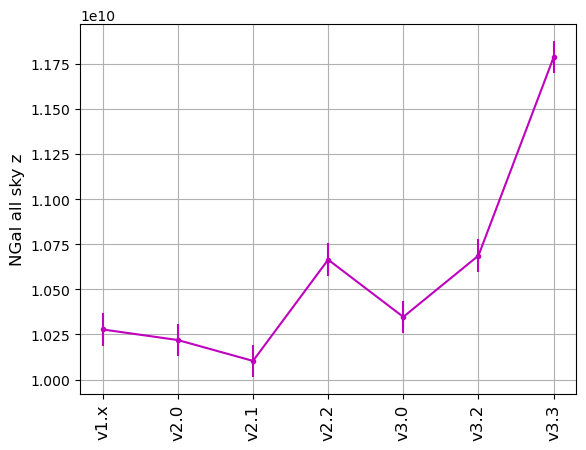

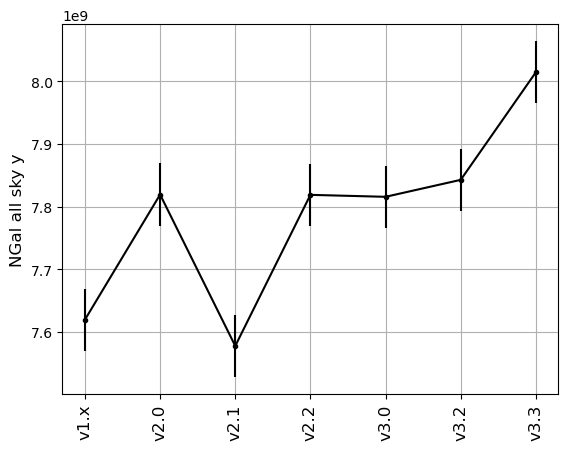

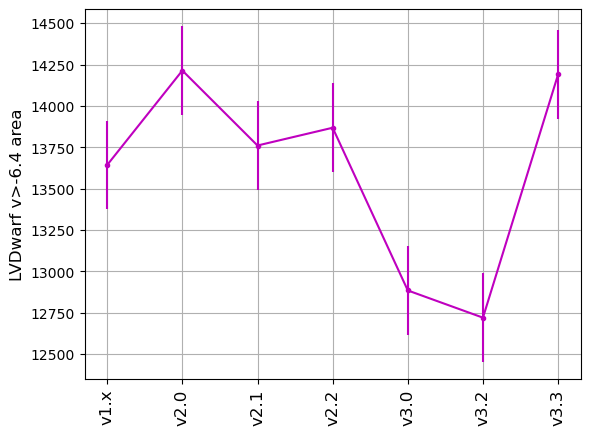

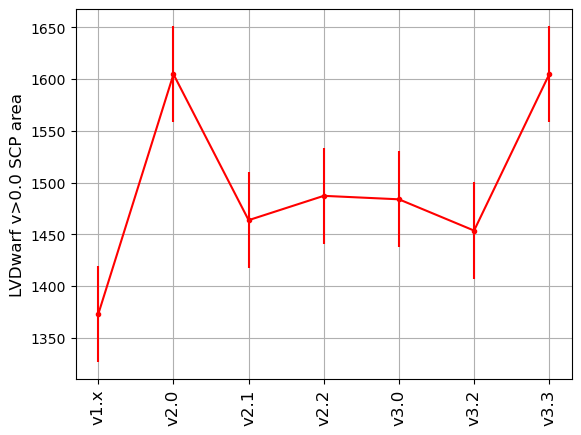

In [44]:
msub = metric_sets.loc['galaxies']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### <a id="Strong Lensing">Strong Lensing</a>

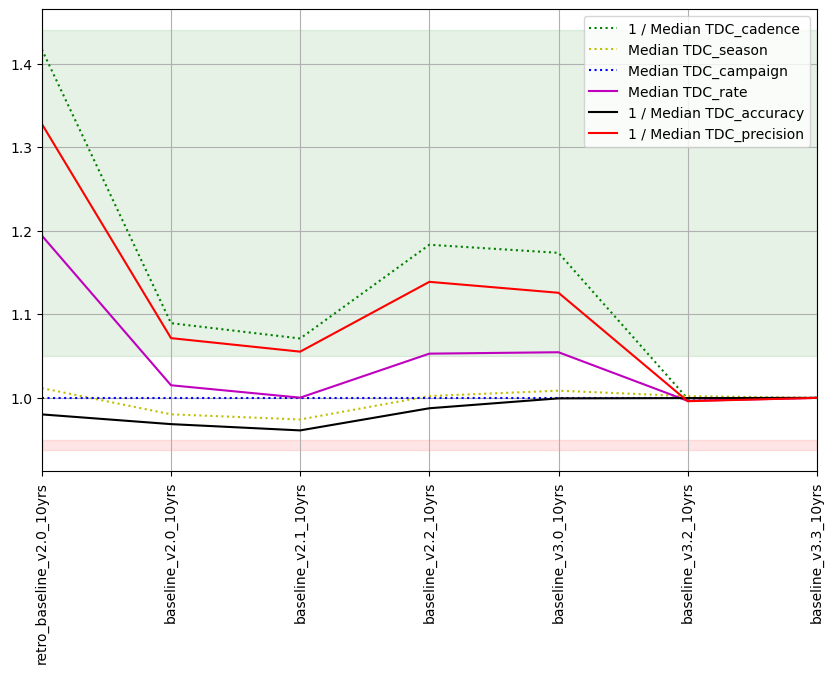

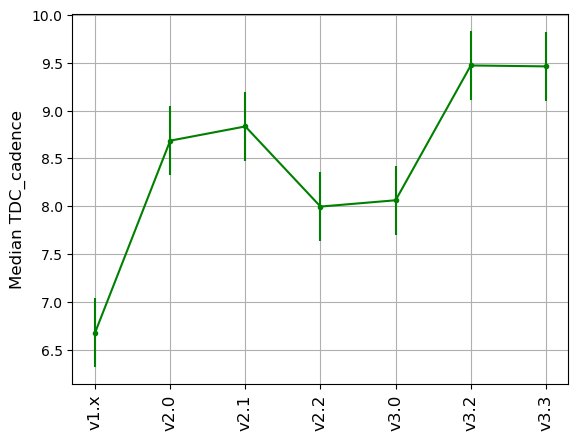

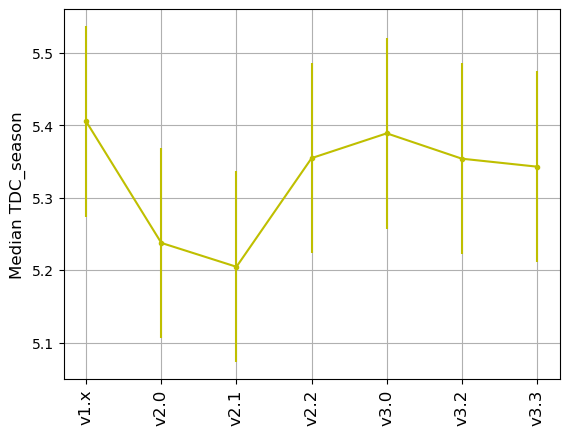

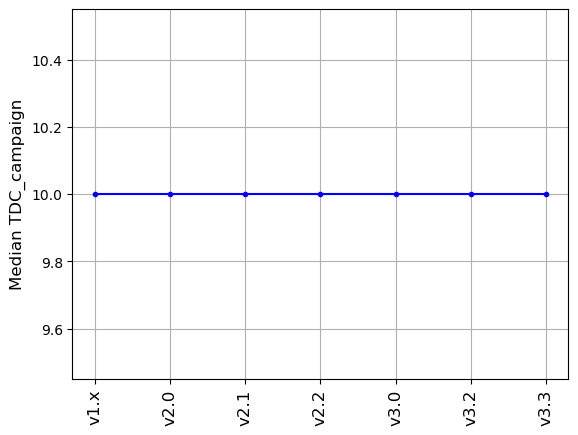

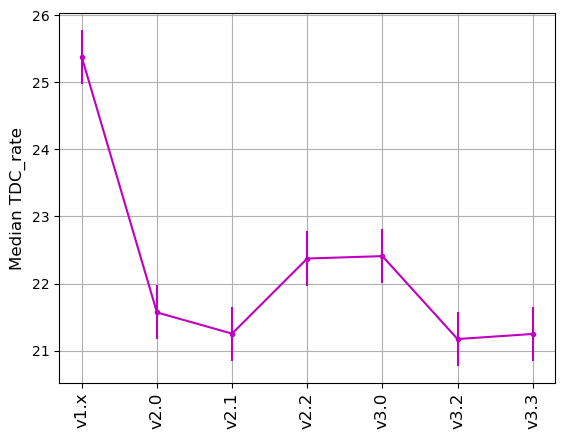

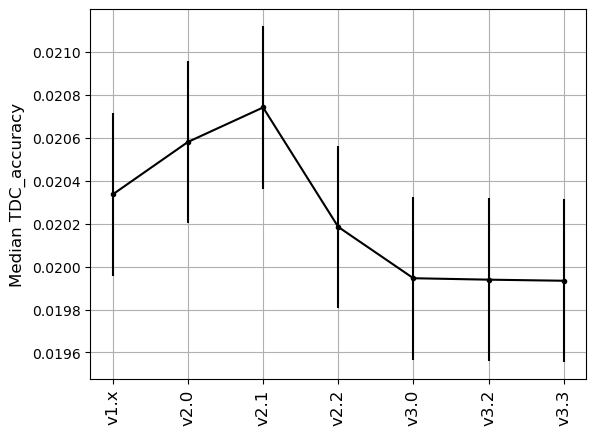

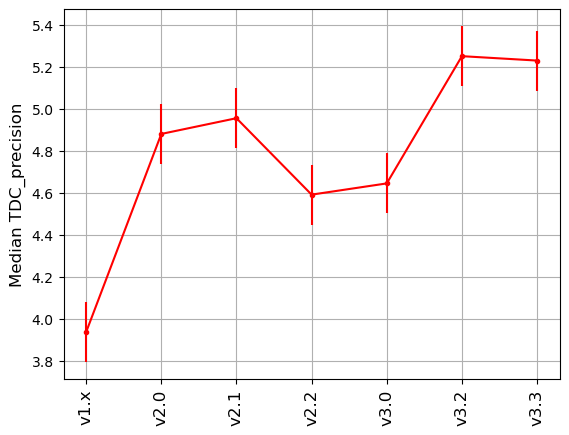

In [45]:
msub = metric_sets.loc['SL TDC']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

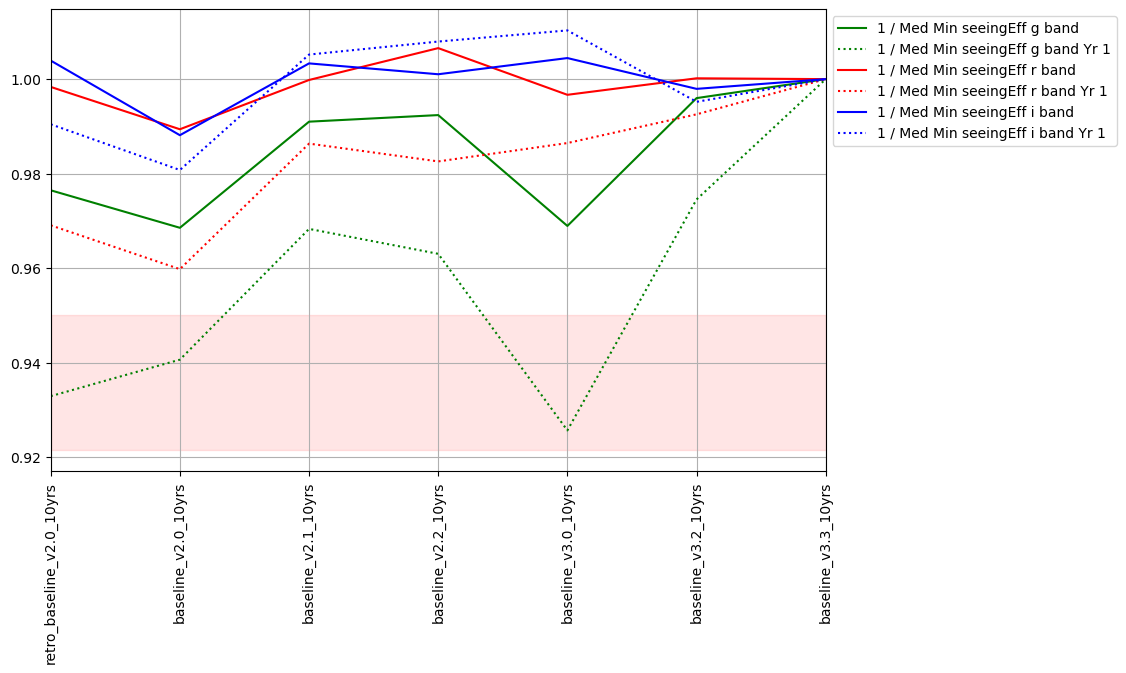

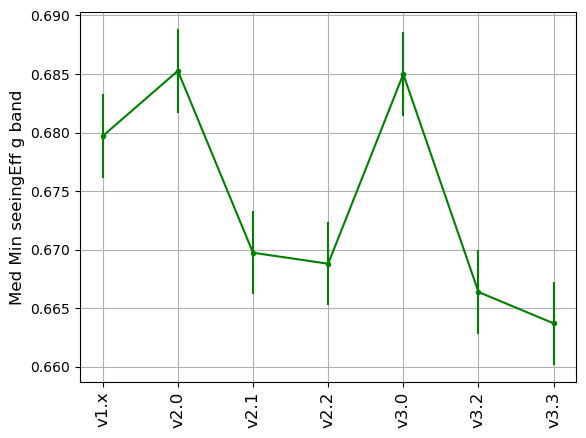

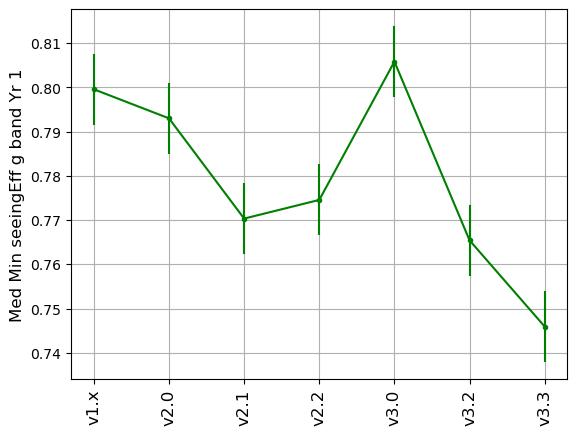

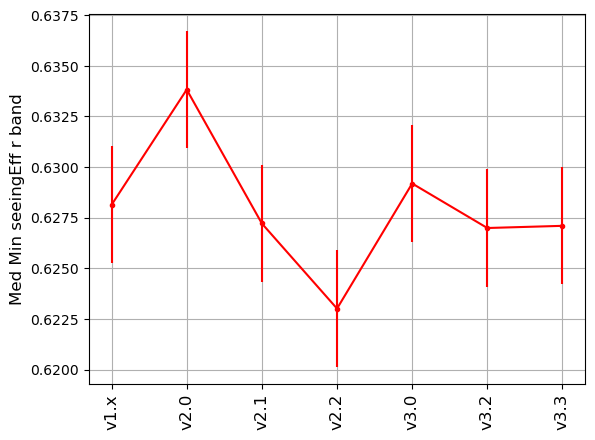

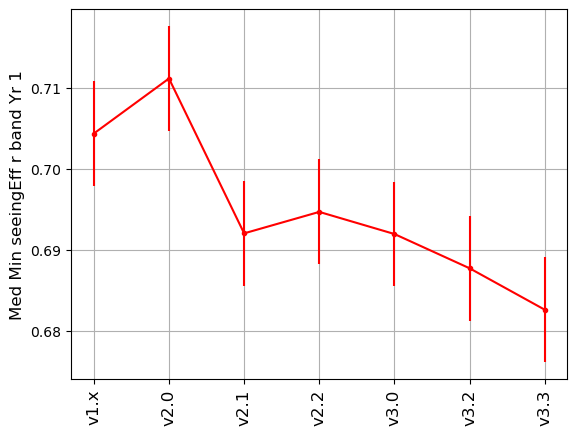

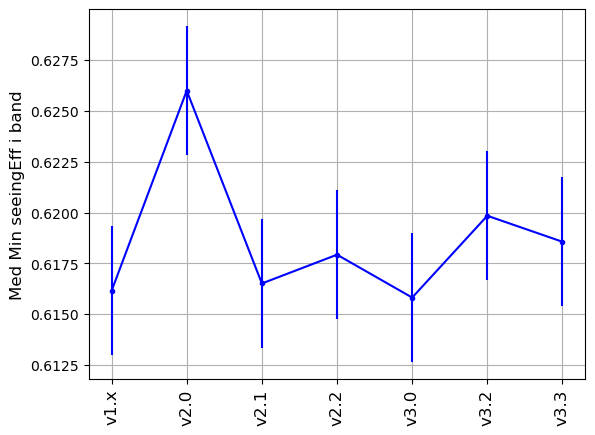

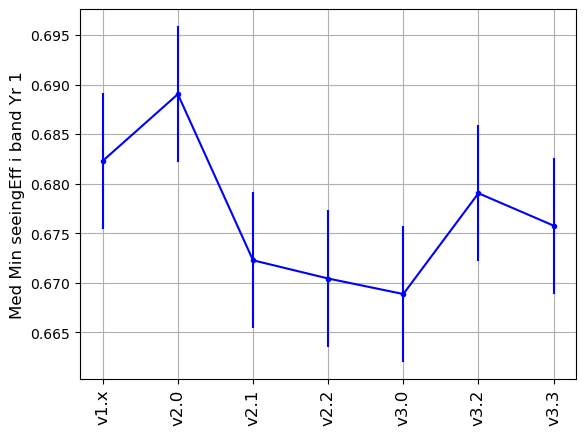

In [46]:
msub = metric_sets.loc['SL IQ']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### <a id="Stars">Stars</a>

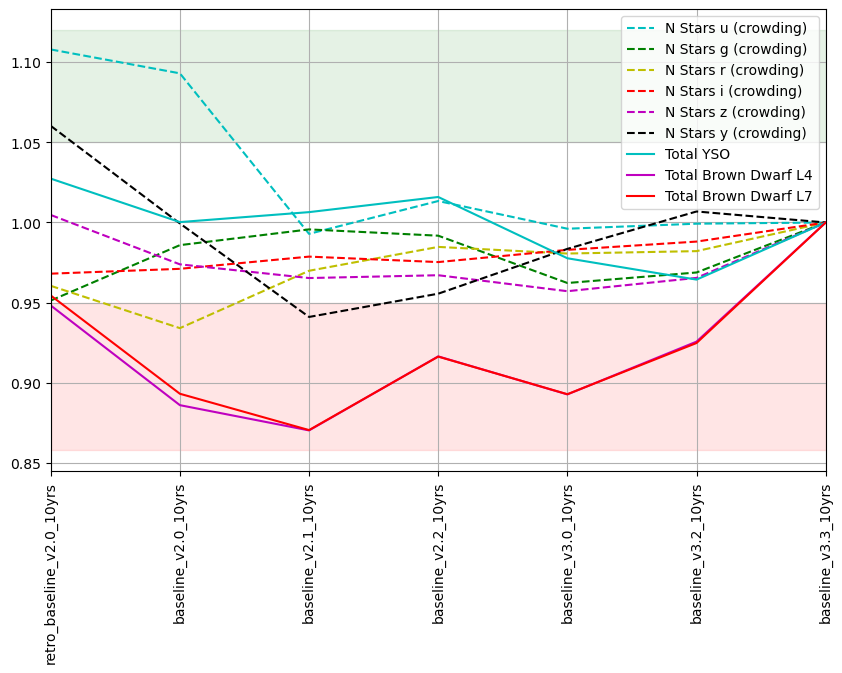

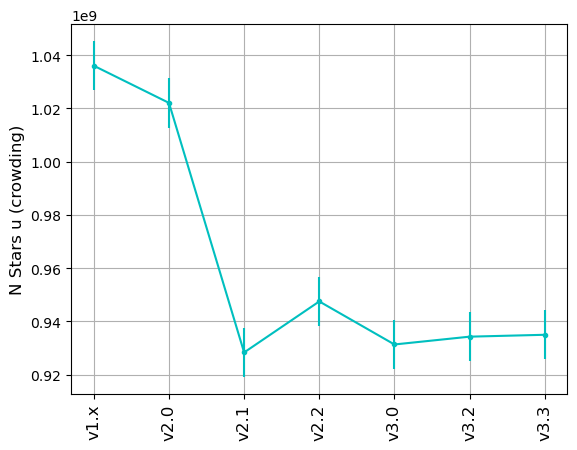

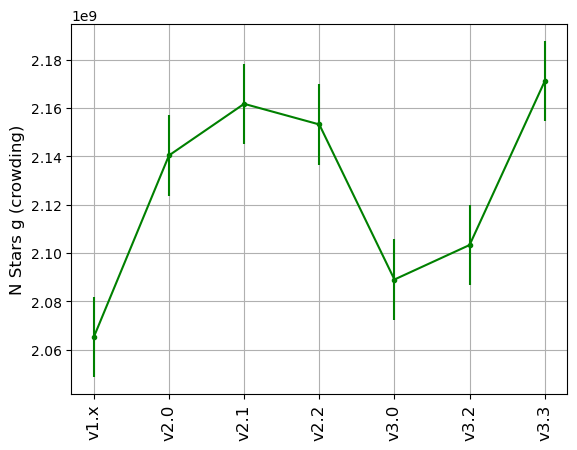

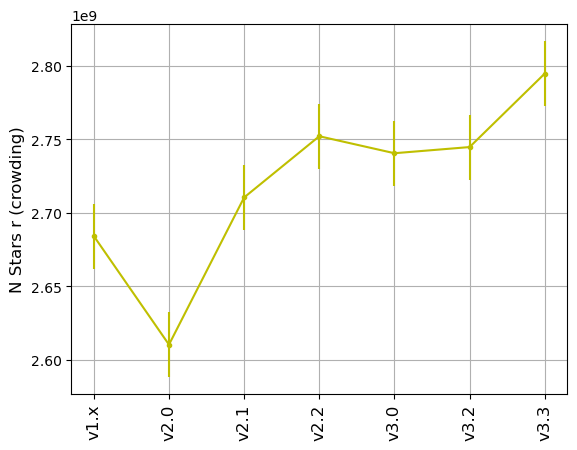

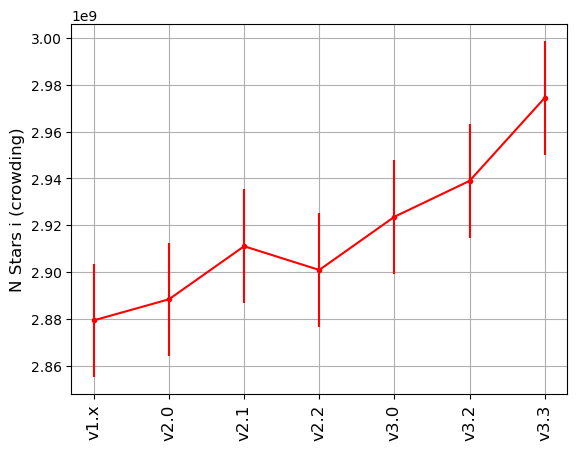

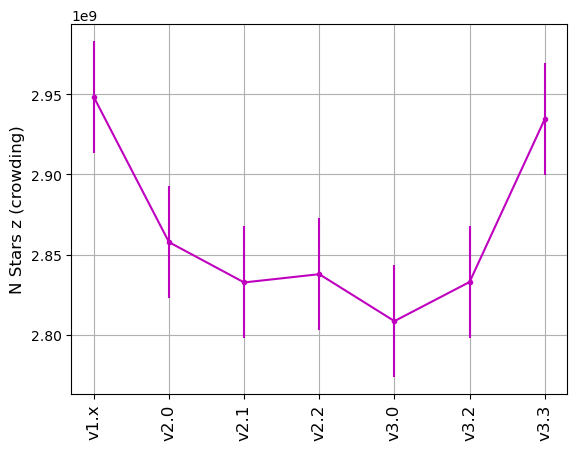

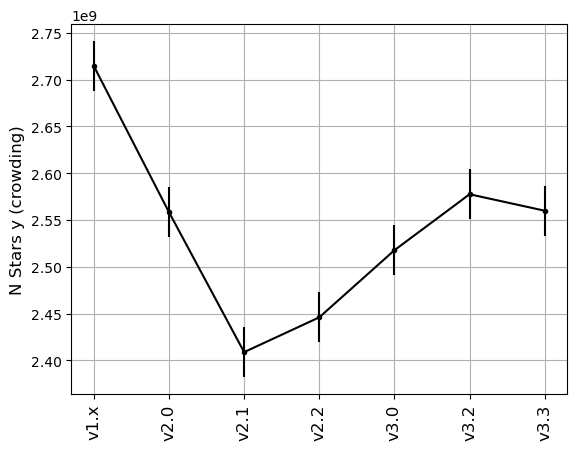

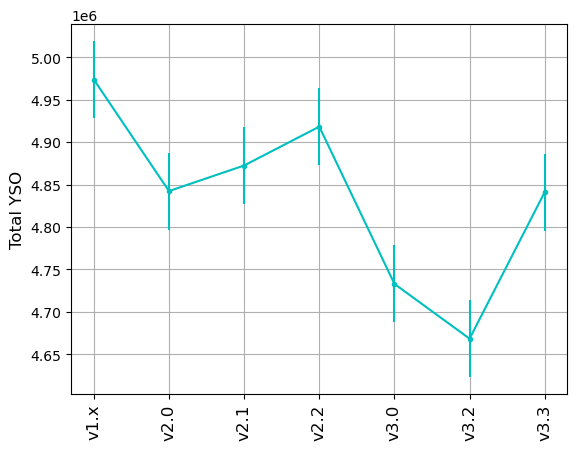

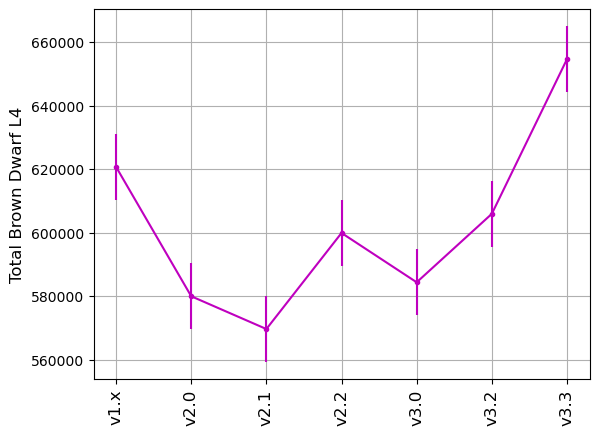

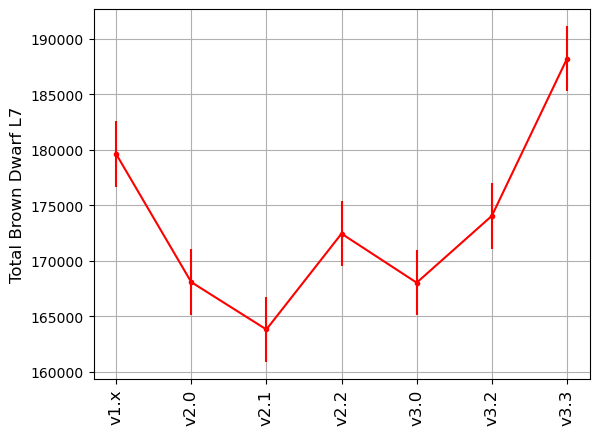

In [47]:
msub = metric_sets.loc['Stars']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid()
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')